In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
from utils_cellular_automata import *
from scipy.ndimage import label
import SimpleITK as sitk
from copy import copy
%matplotlib inline

In [2]:
def fig_multiple3D(ff, r=1, c=4, name='ff', vmin=0, vmax=1):
    '''Plot the middle slice of a 3D array.
    We assume that np.shape(ff) == B'''
    middle_slice = np.shape(np.squeeze(ff[0]))[0]//2 - 1
    fig, ax = plt.subplots(r,c, figsize=(c*2,r*2))
    for idx in range(r*c):
        if r <= 1:
            ax[idx].imshow(np.squeeze(ff[idx])[middle_slice,...])
        else:
            # print(idx,idx//c,idx%c)
            ax[idx//c,idx%c].imshow(np.squeeze(ff[idx])[middle_slice,...], vmin=vmin, vmax=vmax)
            # ax[idx//c,idx%c].text(5,10,f'{np.shape(ff[idx])}, {middle_slice}', color='y')
    for axx in ax.ravel(): axx.axis('off')
    # fig.suptitle(f'{name} {np.shape(ff)}')
    fig.tight_layout()

In [3]:
def fig_save_automata_growing(ID, idx, i, last32, orig32, vmin=0, vmax=1, folder='gifs/images_before_gifs/'):
    fig, ax = plt.subplots(1,3,figsize=(8.5,3))
    ax[0].imshow(last32[15], vmin=vmin, vmax=vmax)
    ax[0].text(2,2,'inpain',color='y', fontsize=12)
    ax[1].imshow(i, vmin=vmin, vmax=vmax)
    ax[1].text(2,2,f'cel aut {idx}',color='y', fontsize=12)
    ax[2].imshow(orig32[15], vmin=vmin, vmax=vmax)
    ax[2].text(2,2,'orig',color='y', fontsize=12)
    for axx in ax.ravel(): axx.axis('off')
    fig.tight_layout()
    plt.savefig(f'{folder}{ID}_{idx:04d}.png')
    plt.close()

In [4]:
def fig_read_figs_and_make_gif2(ID, folder='gifs/images_before_gifs/'):
    files_figures = os.listdir(folder)
    files_figures = np.sort(files_figures)
    images_all = []
    for i in files_figures:
        a = imageio.mimread(f'{folder}{i}')
        os.remove(f'{folder}{i}')
        images_all.append(a[0])
    folder_save = folder.split('/')[0]
    imageio.mimsave(f'{folder_save}/{ID}.gif', images_all, duration=.3)

In [5]:
def pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x, cube_half_size = 40, xpad = 40):
    '''we padd the resampled image because some nodules are close to the border '''
    np_im_pad = np.pad(numpyImage_resampled_inserted,((xpad,xpad),(xpad,xpad),(xpad,xpad)),mode='reflect')
    cube_augmented = np_im_pad[coord_z-cube_half_size+xpad:coord_z+cube_half_size+xpad, coord_y-cube_half_size+xpad:coord_y+cube_half_size+xpad, coord_x-cube_half_size+xpad:coord_x+cube_half_size+xpad]
    assert np.shape(cube_augmented) == (80,80,80)
    return cube_augmented

In [6]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, numpyOrigin, numpySpacing

In [7]:
def resample_scan_sitk(image,spacing, original_shape, new_spacing=[1,1,1], resampling_method=sitk.sitkLinear):

    # reorder sizes as sitk expects them
    spacing_sitk = [spacing[1],spacing[2],spacing[0]]
    new_spacing_sitk = [new_spacing[1],new_spacing[2],new_spacing[0]]
    
    # set up the input image as at SITK image
    img = sitk.GetImageFromArray(image)
    img.SetSpacing(spacing_sitk)                
            
    # set up an identity transform to apply
    affine = sitk.AffineTransform(3)
    affine.SetMatrix(np.eye(3,3).ravel())
    affine.SetCenter(img.GetOrigin())
    
    # make the reference image grid, original_shape, with new spacing
    refImg = sitk.GetImageFromArray(np.zeros(original_shape,dtype=image.dtype))
    refImg.SetSpacing(new_spacing_sitk)
    refImg.SetOrigin(img.GetOrigin())
    
    imgNew = sitk.Resample(img, refImg, affine ,resampling_method, 0)
    
    imOut = sitk.GetArrayFromImage(imgNew).copy()
    
    return imOut

In [8]:
def insert_gan_image_in_no_segmented_lungs(image_patched_relevant, file_one, numpyImage_resampled, mask_correct):
    '''1. the coords of the nodule are in its name.
    2. get a copy of the block around the nodule
    3. denormalize gan-created image and make sure its () similar to the resampled block 
    4. insert gan-created image (just the nodule mask) into the block
    5. put back the block (with the inserted gan-created nodule) into the copy of the resampled image'''
    size_half = 16
    # the coords of the nodule are in its name
    coord_z = int(file_one.split('_z')[-1].split('y')[0])
    coord_y = int(file_one.split('y')[-1].split('x')[0])
    coord_x = int(file_one.split('x')[-1].split('.')[0])
    # get a copy of the block around the nodule
    numpyImage_resampled_inserted = copy(numpyImage_resampled)
    numpyImage_resampled_block = numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half]
    np.shape(numpyImage_resampled_block)
    # denormalize gan-created image and make sure its () similar to the resampled block 
    image_patched_denorm = denormalizePatches(image_patched_relevant)
    assert np.sum(numpyImage_resampled_block == image_patched_denorm) > 1000
    # insert gan-created image (just the nodule mask) into the block
    zz,yy,xx = np.where(mask_correct==1)
    numpyImage_resampled_block[zz,yy,xx] = image_patched_denorm[zz,yy,xx]
    # put back the block (with the inserted gan-created nodule) into the copy of the resampled image
    numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half] = numpyImage_resampled_block
    return numpyImage_resampled_inserted, coord_z, coord_y, coord_x

In [9]:
def find_no_segmented_subfolder_and_read_it(file_one, data_candidates):
    '''find the corresponding subfolder of this image, read it and resample it'''
    # find the corresponding subfolder of this image
    name_original = file_one.split('_')[0] + '.mhd'
    data_dir_subsets = os.listdir(data_candidates)
    data_dir_subsets = [i for i in data_dir_subsets if 'subset' in i]
    data_dir_subsets = np.sort(data_dir_subsets)
    for sub in data_dir_subsets:
        if name_original in os.listdir(f'{data_candidates}{sub}'):
            break
    #read original (no-segmented) image
    numpyImage, numpyOrigin, numpySpacing = load_itk_image(f'{data_candidates}{sub}/{name_original}')
    # resample the image_without_segmentation
    new_spacing = [1,1,1]
    numpyImage_shape = ((np.shape(numpyImage) * numpySpacing) / np.asarray(new_spacing)).astype(int)
    numpyImage_resampled = resample_scan_sitk(numpyImage, numpySpacing, numpyImage_shape, new_spacing=new_spacing)
    return numpyImage_resampled, sub

In [10]:
def patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, ndl_grown):
    '''The only difference in v2 is that we do not pas ca_gen because we pass already one generation
    We patch the celullar-automata-generated (augen) nodule into the inpainted image (inpain)
    The extra mask (part2 < part5) is used to fix some dark spots visible in the patched image.
    This mask is formed by the values that are larger in the inpainted image than in the ca-generated
    image (looking only into the nodule-generated region)'''
    part1 = ((~mask_overlap).astype(int)*last32) # OUT_INPAIN
    part2 = ((mask_overlap).astype(int)*ndl_grown) # IN_NDL
    # part3 = (((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown))
    part4 = part2 > 0 # IN_NDL_MASK
    part5 = last32 * part4 # IN_INPAIN
    part6 = part2 < part5 # IN_PIX_WHERE_NDL<INPAIN
    # part7 = part2 < orig32*part4
    # part8 = part2*(~part6) + last32*part6
    part9 = part2*(~part6) + last32*part6 + part1*(~part4)
    return part9, part4

In [11]:
def insert_gan_image_in_no_segmented_lungs2(image_patched_relevant, file_one, numpyImage_resampled, mask_correct):
    break_flag = False
    '''1. the coords of the nodule are in its name.
    2. get a copy of the block around the nodule
    3. denormalize gan-created image and make sure its () similar to the resampled block 
    4. insert gan-created image (just the nodule mask) into the block
    5. put back the block (with the inserted gan-created nodule) into the copy of the resampled image'''
    size_half = 16
    # the coords of the nodule are in its name
    coord_z = int(file_one.split('_z')[-1].split('y')[0])
    coord_y = int(file_one.split('y')[-1].split('x')[0])
    coord_x = int(file_one.split('x')[-1].split('.')[0])
#     print(coord_z, coord_y, coord_x)
    # get a copy of the block around the nodule
    numpyImage_resampled_inserted = copy(numpyImage_resampled)
    numpyImage_resampled_block = numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half]
#     print(coord_z-size_half,coord_z+size_half, coord_y-size_half,coord_y+size_half, coord_x-size_half,coord_x+size_half)
#     print(np.shape(numpyImage_resampled_block))
    # denormalize gan-created image and make sure its () similar to the resampled block 
    image_patched_denorm = denormalizePatches(image_patched_relevant)
#     print(np.sum(numpyImage_resampled_block == image_patched_denorm))
    if np.sum(numpyImage_resampled_block == image_patched_denorm) < 1000:
        errors.append(file_one)
        break_flag = True
    # insert gan-created image (just the nodule mask) into the block
    zz,yy,xx = np.where(mask_correct==1)
    numpyImage_resampled_block[zz,yy,xx] = image_patched_denorm[zz,yy,xx]
    # put back the block (with the inserted gan-created nodule) into the copy of the resampled image
    numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half] = numpyImage_resampled_block
    return numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag

In [12]:
def fig_final_vs_cagen_vs_orig(cube_augmented, patched_corrected, orig32, name_correct, save=False, folder='gifs/check alignment from patch nodules v2B - loop/'):
    fig, ax = plt.subplots(2,2, figsize=(8,8))
    ax[0,0].imshow(cube_augmented[39]); ax[0,0].text(2,6,'final', color='y', fontsize=14)
    ax[0,1].imshow(cube_augmented[39][24:56,24:56]); ax[0,1].text(2,2,'final (zoom)', color='y', fontsize=14)
    ax[1,0].imshow(patched_corrected[15]); ax[1,0].text(2,2,'cagen', color='y', fontsize=14)
    ax[1,1].imshow(orig32[15]); ax[1,1].text(2,2,'orig', color='y', fontsize=14)
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()
    if save:
        name_save = name_correct.split('.raw')[0] + '.png'
        plt.savefig(f'{folder}{name_save}')
        plt.close()

In [13]:
def fig_compare_masks_against_final_result(mask32, ca_gen, cube_augmented, mask_overlap, mask_ndl_grown, img_gen):
    mask32_profile = np.sum(mask32,(1,2))
    mask_ndl_grown_grown_profile = np.sum(mask_ndl_grown[ca_gen],(1,2))

    fig, ax = plt.subplots(1,8,figsize=(16,2))
    ax[0].imshow(cube_augmented[39])
    ax[1].imshow(cube_augmented[39][39-16: 39+16, 39-16: 39+16])
    ax[1].text(2,4, ca_gen, fontsize=14, color = 'y')
    ax[2].imshow(mask32[15])
    ax[2].text(2,4,'orig', fontsize=14, color = 'y')
    ax[3].imshow(mask_overlap[15])
    ax[3].text(2,4,'overlap', fontsize=14, color = 'y')
    ax[4].imshow(mask_ndl_grown[ca_gen][15])
    ax[4].text(2,4,'ndl_grown', fontsize=14, color = 'y')
    ax[5].imshow(img_gen[ca_gen][15])
    ax[6].plot(mask32_profile)
    ax[6].plot(mask_ndl_grown_grown_profile)
    ax[7].hist(cube_augmented[39][39-16: 39+16, 39-16: 39+16].flatten());
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [14]:
from scipy.ndimage import distance_transform_bf
def get_center_of_volume_from_largest_component_return_center_or_extremes(vol,extreme=0, coord='coord1'):
  '''get largest component and calculate center of irregular volume using distance transform and
  return those coords'''
  assert (extreme==0 or extreme==1)
  # get largest component
  mask_multiple, cc_num = label(vol > 0)
  sorted_comp = np.bincount(mask_multiple.flat)
  sorted_comp = np.sort(sorted_comp)[::-1]
  comp_largest = (mask_multiple == np.where(np.bincount(mask_multiple.flat) == sorted_comp[1])[0][0])
  if extreme == 0:
    # calculate center of irregular volume using distance transform
    center_volume = distance_transform_bf(comp_largest.astype('float'))
    center_z,center_y,center_x = np.where(center_volume == np.max(center_volume))
    center_z,center_y,center_x = center_z[0],center_y[0],center_x[0]
  if extreme == 1:
    coord1, coord2 = largest_distance(ndl)
    if coord == 'coord2':
      center_z,center_y,center_x = coord2
    else:
      center_z,center_y,center_x = coord1

  return center_z,center_y,center_x

In [15]:
def get_component_center(mask32, farthest=False):
    '''from the different components, find the one that is closest to the center'''
    label_mask32, nr = label(mask32)
    dist_small = 1000
    if farthest:
        dist_small = 0
    for i in np.arange(1,nr+1):
        
        mm = label_mask32==i
        center_z,center_y,center_x = get_center_of_volume_from_largest_component_return_center_or_extremes(mm)
        dist = np.linalg.norm(np.asarray([center_z,center_y,center_x])-np.asarray([16,16,16]))
        if dist<dist_small:
            mask_center = mm
            dist_small = dist
        if farthest:
            if dist>dist_small:
                mask_center = mm
                dist_small = dist
    # call_subplots([mask_center])
    if farthest == True and 'mask_center' not in locals():
        mask_center=np.ones_like(mm)
    return mask_center

In [16]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
def plot_3d(image, threshold=-300, detail_speed=1, figsize=(6,6)):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(1,2,0)
    p = p.transpose(1,0,2)
    p = p[:,::-1,:]

    verts, faces, _, _ = measure.marching_cubes_lewiner(p, threshold, step_size=detail_speed)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.5)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()
def subplot_3d_one_fig(image, global_fig, threshold=-300, detail_speed=1, figsize=(6,6), sub=161, color=[.5, .5, 1]):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(1,2,0)
    p = p.transpose(1,0,2)
    p = p[:,::-1,:]

    verts, faces, _, _ = measure.marching_cubes_lewiner(p, threshold, step_size=detail_speed)

    ax = global_fig.add_subplot(sub, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.5)
    face_color = color
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    return ax
def call_subplots(imm, imm2=False, threshold=.1, detail_speed=2, color=[.5, .5, 1]):
    global global_fig
    width = int(len(imm)*4)
    global_fig = plt.figure(figsize=(width,6))
    imm_str = [int('1'+str(len(imm))+str(i)) for i in np.arange(1,len(imm)+1)]
    if imm2:
        for img, img2, i in zip(imm, imm2, imm_str):  
            subplot_3d_two_figs(img, img2, global_fig, threshold=threshold, detail_speed=detail_speed, figsize=(6,6), sub=i, color=color, color2=[1, .6, .6])
    else:
        for img, i in zip(imm, imm_str):
            subplot_3d_one_fig(img, global_fig, threshold=threshold, detail_speed=detail_speed, figsize=(6,6), sub=i, color=color)

In [17]:
def subplot_3d_two_figs(image, image2, global_fig, threshold=-300, detail_speed=1, detail_speed2=1, figsize=(6,6), sub=161, color=[.5, .5, 1], color2=[.5, 1, 0.5]):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(1,2,0)
    p = p.transpose(1,0,2)
    p = p[:,::-1,:]

    p2 = image2.transpose(1,2,0)
    p2 = p2.transpose(1,0,2)
    p2 = p2[:,::-1,:]

    verts, faces, _, _ = measure.marching_cubes_lewiner(p, threshold, step_size=detail_speed)
    verts2, faces2, _, _ = measure.marching_cubes_lewiner(p2, threshold, step_size=detail_speed2)

    ax = global_fig.add_subplot(sub, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.3)
    face_color = color
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    # figure 2
    mesh2 = Poly3DCollection(verts2[faces2], alpha=0.99)
    face_color2 = color2
    mesh2.set_facecolor(face_color2)
    ax.add_collection3d(mesh2)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    return ax

In [18]:
def insert_gan_image_in_no_segmented_lungs3(image_patched_relevant, file_one, numpyImage_resampled, mask_correct):
    break_flag = False
    THRESHOLD_CORRECTION = -960
    '''1. the coords of the nodule are in its name.
    2. get a copy of the block around the nodule
    3. denormalize gan-created image and make sure its () similar to the resampled block 
    4. insert gan-created image (just the nodule mask) into the block
    5. put back the block (with the inserted gan-created nodule) into the copy of the resampled image'''
    size_half = 16
    # the coords of the nodule are in its name
    coord_z = int(file_one.split('_z')[-1].split('y')[0])
    coord_y = int(file_one.split('y')[-1].split('x')[0])
    coord_x = int(file_one.split('x')[-1].split('.')[0])
#     print(coord_z, coord_y, coord_x)
    # get a copy of the block around the nodule
    numpyImage_resampled_inserted = copy(numpyImage_resampled)
    numpyImage_resampled_block = numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half]
#     print(coord_z-size_half,coord_z+size_half, coord_y-size_half,coord_y+size_half, coord_x-size_half,coord_x+size_half)
#     print(np.shape(numpyImage_resampled_block))
    # denormalize gan-created image and make sure its () similar to the resampled block 
    image_patched_denorm = denormalizePatches(image_patched_relevant)
#     print(np.sum(numpyImage_resampled_block == image_patched_denorm))
    if np.sum(numpyImage_resampled_block == image_patched_denorm) < 1000:
        errors.append(file_one)
        break_flag = True
    # insert gan-created image (just the nodule mask) into the block
    zz,yy,xx = np.where(mask_correct==1)
    zz,yy,xx = np.where(image_patched_denorm > -960)
    numpyImage_resampled_block[zz,yy,xx] = image_patched_denorm[zz,yy,xx]
    # Correction v3
    z_correction, y_correction, x_correction = np.where(image_patched_denorm < THRESHOLD_CORRECTION)
    numpyImage_resampled_block[z_correction, y_correction, x_correction]
    
    # put back the block (with the inserted gan-created nodule) into the copy of the resampled image
    numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half] = numpyImage_resampled_block
    
#     zz_correction, yy_correction, xx_correction = np.where(numpyImage_resampled_inserted < -THRESHOLD_CORRECTION)
#     numpyImage_resampled_inserted[zz_correction, yy_correction, xx_correction] = numpyImage_resampled[zz_correction, yy_correction, xx_correction]
    
    return numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag

In [19]:
def center_automata_in_generation(img, generation=80, size=32):
    hsz = size//2
    img_gen_centered = img[generation]
    img_gen_centered = np.pad(img_gen_centered,((100,100),(100,100),(100,100)),constant_values=0)
    center_z_gen, center_y_gen, center_x_gen = get_center_of_volume_from_largest_component_return_center_or_extremes(img_gen_centered)
    img_centered = []
    for i in img:
        i = np.pad(i, ((100,100),(100,100),(100,100)),constant_values=0)
        i = i[center_z_gen-hsz:center_z_gen+hsz, center_y_gen-hsz:center_y_gen+hsz, center_x_gen-hsz:center_x_gen+hsz]
        img_centered.append(i)
    return img_centered

In [20]:
def center_automata_in_generation_in_mask(img, mask, generation=80, size=32):
    '''center the automata-generated images in the coordinates of the center of the original mask'''
    m0,m1,m2 = get_center_of_volume_from_largest_component_return_center_or_extremes(mask)
    img_gen_centered = img[generation]
    img_gen_centered = np.pad(img_gen_centered,((100,100),(100,100),(100,100)),constant_values=0)
    b0,b1,b2 = get_center_of_volume_from_largest_component_return_center_or_extremes(img_gen_centered>0)
    c00,c01 = m0, int(size-m0)
    c10,c11 = m1, int(size-m1)
    c20,c21 = m2, int(size-m2)
    img_centered = []
    for i in img:
        i = np.pad(i, ((100,100),(100,100),(100,100)),constant_values=0)
        i = i[b0-c00:b0+c01, b1-c10:b1+c11, b2-c20:b2+c21]
        img_centered.append(i)
    return img_centered

In [21]:
!pwd

/home/om18/Documents/KCL/Nov_27_19_cellular_automata


In [18]:
# 1. Make sure that nodules_sorted == nodules_sorted2
# path_drive = '/data/OMM/Datasets/Growing Celullar Automata Nodules/files in drive/'
## path_candidates = '/data/OMM/Datasets/LUNA/'
## path_dest = '/data/OMM/project results/Mar 02 20 - Cellular Automata Generated Images BATCH3/'

# nodules_sorted = np.load(f'{path_drive}nodules_sorted.npz')
# nodules_sorted2 = np.load(f'{path_drive}nodules_sorted2.npz')
# nodules_sorted = nodules_sorted.f.arr_0
# nodules_sorted2 = nodules_sorted2.f.arr_0

# # Make sure that nodules_sorted == nodules_sorted2
# for idx, (a,b) in enumerate(zip(nodules_sorted, nodules_sorted2)):
#     assert((a==b).all() == True)
#     if (a==b).all() == False: print(idx)
        
# # Delete large vars
# del nodules_sorted, nodules_sorted2

In [22]:
!ls /data/OMM/project_results/Jun_17_2020_cell_aut_grown_nodules/batch_center/

ca_nodules_generated_center	   ca_nodules_generated_coord1_2comp
ca_nodules_generated_center_2comp  ca_nodules_generated_coord2
ca_nodules_generated_center_G	   ca_nodules_generated_coord2_2comp
ca_nodules_generated_coord1	   temp


In [24]:
path_candidates = '/data/OMM/Datasets/LUNA/'
path_dest = '/data/OMM/project_results/Jun_17_2020_cell_aut_grown_nodules/batch_center/ca_nodules_generated_center_G/'

## 2. Check the indices of the nodules that were already grown with celullar automata

In [25]:
# FIRST BATCH
# Read nodules grown with automata
path_source = path_dest#'/data/OMM/project_results/Jun_17_2020_cell_aut_grown_nodules/batch_center/ca_nodules_generated_coord1/'
files_all = os.listdir(path_source)
files_ndls = [i for i in files_all if 'npz' in i]
print(f'files after automata:\nfiles_all (include weights, names and images) = {len(files_all)},files_ndls = {len(files_ndls)}')
files_ndls_raw = [i.split('.npz')[0] for i in files_ndls]

# Reads files from sorting operation (these were the ones that were entered into the automata)
path_sorting = '/home/om18/Documents/KCL/Nov_27_19_cellular_automata/'
files_sorted = np.load(f'{path_sorting}files_sorted.npy')
files_ndls_sorted = np.load(f'{path_sorting}nodules_sorted2.npz')
files_ndls_sorted = files_ndls_sorted.f.arr_0
print(f'files before automata:\nfiles_sorted (names) = {len(files_sorted)}, files_ndls_sorted (images) = {len(files_ndls_sorted)}')

files after automata:
files_all (include weights, names and images) = 150,files_ndls = 149
files before automata:
files_sorted (names) = 2292, files_ndls_sorted (images) = 2292


----

# From all nodules get the ones used according to colab

In [ ]:
# GET ALL FILES WHERE THERE IS > 1 CONNECTED COMPONENTS (FUNCTION from COLAB)
assert 1==0
nodules_sorted = files_ndls_sorted
nodules_smaller = nodules_sorted
filenames_sorted = files_sorted
nodules_centered, names_centered = [], []
zs, ys, xs = [], [], []
for idx, (i, name) in tqdm_notebook(enumerate(zip(nodules_smaller, filenames_sorted)), total = len(nodules_smaller)):
    labelled, nr = label(i)
    if nr > 1: 
        m = i > 0
        zz,yy,xx = np.where(m==1)
        zzz = int(np.median(zz)); yyy = int(np.median(yy)); xxx = int(np.median(xx))
        ndl_centered = i[zzz-16:zzz+16, yyy-16:yyy+16, xxx-16:xxx+16]
        if np.shape(ndl_centered) == (32,32,32):
            nodules_centered.append(ndl_centered)
            names_centered.append(name)
            zs.append(zzz)
            ys.append(yyy)
            xs.append(xxx)
nodules_smaller = np.expand_dims(nodules_centered,1)
print(f'nodules_sorted = {np.shape(nodules_sorted)}, nodules_smaller = {np.shape(nodules_smaller)}')
# 3D versions
nodules3D = [np.swapaxes(i,0,1) for i in nodules_smaller]
nodules3D = [np.swapaxes(i,1,2) for i in nodules3D]
nodules3D = [np.swapaxes(i,2,3) for i in nodules3D]
print(np.shape(nodules3D))

In [ ]:
# (DO NOT USE) CODE FROM COLAB FOR PAPER
assert 1==0
nodules_sorted = np.load('/content/gdrive/My Drive/KCL/cellular automata v2/nodules_sorted3.npz')
filenames_sorted = np.load('/content/gdrive/My Drive/KCL/cellular automata v2/files_sorted3.npy')
#nodules_sorted = np.load('/home/om18/Documents/KCL/Nov_27_19_cellular_automata/nodules_sorted.npz')
nodules_sorted = nodules_sorted.f.arr_0
# For now work only with 32x32x32
nodules_smaller = nodules_sorted[:,16:-16, 16:-16, 16:-16]
# only use those images that include only 1 nodule
nodules_centered, names_centered = [], []
for i, name in zip(nodules_smaller, filenames_sorted):
    labelled, nr = label(i)
    if nr == 1:
      nodules_centered.append(i)
      names_centered.append(name)
nodules_smaller = np.expand_dims(nodules_centered,1)
print(f'nodules_sorted = {np.shape(nodules_sorted)}, nodules_smaller = {np.shape(nodules_smaller)}')
# 3D versions
nodules3D = [np.swapaxes(i,0,1) for i in nodules_smaller]
nodules3D = [np.swapaxes(i,1,2) for i in nodules3D]
nodules3D = [np.swapaxes(i,2,3) for i in nodules3D]
print(np.shape(nodules3D))

fig_multiple3D(nodules3D[1610:],r=4,c=4,name='nodules 1400')

In [ ]:
# Jun 2020: THIS WAS USED FOR BATCHES A,B,C 
assert 1 == 0 
nodules_sorted = files_ndls_sorted
nodules_smaller = nodules_sorted[:,16:-16, 16:-16, 16:-16] # For now work only with 32x32x32
filenames_sorted = files_sorted
nodules_centered, names_centered = [], []
zs, ys, xs = [], [], []
for idx, (i, name) in tqdm_notebook(enumerate(zip(nodules_smaller, filenames_sorted)), total = len(nodules_smaller)):
    labelled, nr = label(i)
    if nr == 1:
        nodules_centered.append(i)
        names_centered.append(name)
nodules_smaller = np.expand_dims(nodules_centered,1)
print(f'nodules_sorted = {np.shape(nodules_sorted)}, nodules_smaller = {np.shape(nodules_smaller)}')
# 3D versions
nodules3D = [np.swapaxes(i,0,1) for i in nodules_smaller]
nodules3D = [np.swapaxes(i,1,2) for i in nodules3D]
nodules3D = [np.swapaxes(i,2,3) for i in nodules3D]
print(np.shape(nodules3D))

In [ ]:
# Jun 2020: THIS WAS USED FOR BATCH D 
assert 1 == 0 
nodules_sorted = files_ndls_sorted
filenames_sorted = files_sorted
nodules_smaller = nodules_sorted
# only use those images that include only 1 nodule
nodules_centered, names_centered, coords_centered = [], [], []
for idx, (i, name) in tqdm_notebook(enumerate(zip(nodules_smaller, filenames_sorted)), total = len(nodules_smaller)):
    labelled, nr = label(i)
    if nr > 1: 
      m = i > 0
      z64,y64,x64 = np.where(m==1)
      zMedian = int(np.median(z64)); yMedian = int(np.median(y64)); xMedian = int(np.median(x64))
      ndl_centered = i[zMedian-16:zMedian+16, yMedian-16:yMedian+16, xMedian-16:xMedian+16]
      if np.shape(ndl_centered) == (32,32,32):
        nodules_centered.append(ndl_centered)
        names_centered.append(name)
        coords_centered.append([z64, y64, x64])
nodules_smaller = np.expand_dims(nodules_centered,1)
# 3D versions
nodules3D = [np.swapaxes(i,0,1) for i in nodules_smaller]
nodules3D = [np.swapaxes(i,1,2) for i in nodules3D]
nodules3D = [np.swapaxes(i,2,3) for i in nodules3D]
print(np.shape(nodules3D))

In [92]:
# Jun 2020: THIS WAS USED FOR BATCHES E, F
assert 1 == 0
nodules_sorted = files_ndls_sorted
filenames_sorted = files_sorted
nodules_smaller = nodules_sorted
# only use those images that include only 1 nodule
nodules_centered, names_centered, coords_centered = [], [], []
ndl_previous = np.zeros((32,32,32)); ndl_unique = []
for idx, (i, name) in tqdm_notebook(enumerate(zip(nodules_smaller, filenames_sorted)), total = len(nodules_smaller)):
    labelled, nr = label(i)
    if nr > 1: 
      m = i > 0
      zz,yy,xx = np.where(m==1)
      zzz = int(np.median(zz)); yyy = int(np.median(yy)); xxx = int(np.median(xx))
      ndl_centered = i[zzz-16:zzz+16, yyy-16:yyy+16, xxx-16:xxx+16]
      if np.shape(ndl_centered) == (32,32,32):
        equal = (np.squeeze(ndl_centered) == ndl_previous).all()
        ndl_previous = np.squeeze(ndl_centered)
        if equal == False:
          nodules_centered.append(ndl_centered)
          names_centered.append(name)
          coords_centered.append([zz,yy,xx])
nodules_smaller = np.expand_dims(nodules_centered,1)
print(f'nodules_sorted = {np.shape(nodules_sorted)}, nodules_smaller = {np.shape(nodules_smaller)}')
# 3D versions
nodules3D = [np.swapaxes(i,0,1) for i in nodules_smaller]
nodules3D = [np.swapaxes(i,1,2) for i in nodules3D]
nodules3D = [np.swapaxes(i,2,3) for i in nodules3D]
print(np.shape(nodules3D))


nodules_sorted = (2292, 64, 64, 64), nodules_smaller = (528, 1, 32, 32, 32)
(528, 32, 32, 32, 1)


In [26]:
# Jun 2020: THIS WAS USED FOR BATCH G
nodules_sorted = files_ndls_sorted
filenames_sorted = files_sorted
nodules_smaller = nodules_sorted
# only use those images that include only 1 nodule
nodules_centered, names_centered, coords_centered = [], [], []
ndl_previous = np.zeros((32,32,32)); ndl_unique = []
for idx, (i, name) in tqdm_notebook(enumerate(zip(nodules_smaller, filenames_sorted)), total = len(nodules_smaller)):
    labelled, nr = label(i)
    if nr > 1: 
      m = i > 0
      zz,yy,xx = np.where(m==1)
      zzz = int(np.median(zz)); yyy = int(np.median(yy)); xxx = int(np.median(xx))
      ndl_centered = i[zzz-16:zzz+16, yyy-16:yyy+16, xxx-16:xxx+16]
      if np.shape(ndl_centered) == (32,32,32):
        if ndl_centered[16,16,16] == 0: #added for version 9.1aa
          nodules_centered.append(ndl_centered)
          names_centered.append(name)
          coords_centered.append([zz,yy,xx])
nodules_smaller = np.expand_dims(nodules_centered,1)
print(f'nodules_sorted = {np.shape(nodules_sorted)}, nodules_smaller = {np.shape(nodules_smaller)}')
# 3D versions
nodules3D = [np.swapaxes(i,0,1) for i in nodules_smaller]
nodules3D = [np.swapaxes(i,1,2) for i in nodules3D]
nodules3D = [np.swapaxes(i,2,3) for i in nodules3D]
print(np.shape(nodules3D))


nodules_sorted = (2292, 64, 64, 64), nodules_smaller = (150, 1, 32, 32, 32)
(150, 32, 32, 32, 1)


---

# Make sure the images generated by the automata match orig32 and last32

In [22]:
# From 1 image used in (BATCH3) get the corresponding inpain and orig
print(f'total_images_analyzed (in the subset of BATCH3) = {len(path_source)}')
# ids_chosen = [1, 12, 16, 18, 25, 27, 28, 30, 32, 37, 41, 43, 46, 47, 48, 51, 61, 71, 96, 103, 104, 109, 123]
ids_chosen = [i for i in range(19)]
FILES = os.listdir(path_source)
FILES = [i for i in FILES if '.npz' in i]
for idx, idx2name in enumerate(ids_chosen):
    if idx==8: #break
        name_correct = FILES[idx2name]
    #     print(name_correct)
        coords_ch = coords_centered[idx2name]
        zzz = int(np.median(coords_ch[0])); yyy = int(np.median(coords_ch[1])); xxx = int(np.median(coords_ch[2]))
        zz,yy,xx = zzz-0,yyy-0,xxx-0
        img_gen = np.load(f'{path_source}{name_correct}')
        img_gen = img_gen.f.arr_0
        # Get the images used in inpainting
        path_data = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/'
        last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
        last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
        
        mask_center = get_component_center(mask32)
        overlaps = [np.sum(np.logical_and(mask_center, (i>0).astype('float')))/np.sum(mask_center) for i in img_gen]
        img_gens_centered = center_automata_in_generation(img_gen)
        overlaps_cent = [np.sum(np.logical_and(mask_center, (i>0).astype('float')))/np.sum(mask_center) for i in img_gens_centered]
        # ===
        
        for idxx, CAGEN in enumerate(img_gens_centered):
            mask_overlap  = np.logical_and(CAGEN>0, mask32)
            patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, CAGEN)
            fig_save_automata_growing(name_correct, idxx, patched_corrected[15], last32, orig32, vmin=0, vmax=1, folder='gifs2/images_before_gifs/')
            
            
            
            
        fig_read_figs_and_make_gif2(name_correct, folder='gifs2/images_before_gifs/')

total_images_analyzed (in the subset of BATCH3) = 108


IndexError: list index out of range

In [33]:
FILES = os.listdir(path_source)
FILES = [i for i in FILES if '.npz' in i]
len(FILES), np.where(np.asarray(FILES)=='1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561266624992539111877_block1_432_z249y132x130.raw.npz')

(527, (array([10]),))

In [26]:
path_dest

'/data/OMM/project_results/Jun_17_2020_cell_aut_grown_nodules/batch_center/ca_nodules_generated_center_G/'

In [27]:
SAVE_FIGS = 40
gen_range = np.arange(100)
FILES = os.listdir(path_source)
FILES = [i for i in FILES if '.npz' in i]
mselosses, min_losses, min_losses_idx, errors = [], [], [], []
path_data = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/' # Get the images used in inpainting
mask_ovelaps_all = []

In [30]:
idx, name_correct = 0, FILES[0]
print(name_correct)
last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
# Read original CT image (not even segmented)
numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)

1.3.6.1.4.1.14519.5.2.1.6279.6001.273525289046256012743471155680_block1_876543210_z38y258x151.raw.npz


In [31]:
path_candidates

'/data/OMM/Datasets/LUNA/'

In [40]:
# MAIN BLOCK PATCH CA IMAGES 
SAVE_FIGS = 40
gen_range = np.arange(100)
FILES = os.listdir(path_source)
FILES = [i for i in FILES if '.npz' in i]
mselosses, min_losses, min_losses_idx, errors = [], [], [], []
path_data = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/' # Get the images used in inpainting
mask_ovelaps_all = []
for idx, name_correct in tqdm_notebook(enumerate(FILES), total=len(FILES)):
    
    if idx==40: break
    
#     if idx==24:

    # Get the images used in inpainting
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    # Read the NCA generated
    img_gens = np.load(f'{path_source}{name_correct}')
    img_gens = img_gens.f.arr_0
    # mask_ndl_grown = img_gens > 0

    mseloss = []
    min_loss = 1
    min_loss_one = []

#     img_gens = center_automata_in_generation(img_gens) # WARNING: THIS IS THE (?) POSSIBLE NEW VERSION
    img_gens = center_automata_in_generation_in_mask(img_gens, mask32)
    mask_overlaps = []

    for ca_gen, img_gen in enumerate(img_gens):
        mask_overlap  = np.logical_and((img_gen>0).astype('float'), mask32)
        

        if np.sum(mask_overlap) > 0:
            patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, img_gen)
            mask_overlaps.append(np.sum(mask_overlap)/np.sum(mask32))

            # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
            # insert_gan_image_in_no_segmented_lungs3 was used for components > 1
            numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs3(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
#             numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) 
            if break_flag: break
            cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)

            # save augmented data
            if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
                os.makedirs(f'{path_dest}patched/{subfolder_save}')
            if ca_gen >= 2: #skip first two generations
                name_correcr_modified = name_correct.split('.raw')[0]
                cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correcr_modified}_epD{ca_gen:03d}')

            loss_new = np.mean((orig32*mask32 - img_gen*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)

            if loss_new < min_loss: #break if the loss increases but...
                min_loss = loss_new
                ca_gen_min = ca_gen

            elif ca_gen>30: break # ...allow a few epochs in the beginning because the masks might not be aligned
            else: pass
            mseloss.append(loss_new) 

            # save a few ID for gif
            if idx % SAVE_FIGS > -1:
            # if idx % SAVE_FIGS == 0: #WARNING PUT THIS ONE BACK
                fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32, folder='gifs2/images_before_gifs/')
                
    mselosses.append(mseloss)
    mask_ovelaps_all.append(mask_overlaps)

    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
    fig_final_vs_cagen_vs_orig(cube_augmented, patched_corrected, orig32, name_correct, True, folder='gifs2/check_alignment_from_patch_nodules_v2B_loop/')

#     if idx % SAVE_FIGS > -1:
    # if idx % SAVE_FIGS == 0: #WARNING PUT THIS ONE BACK
#         fig_read_figs_and_make_gif2(name_correct, folder='gifs2/images_before_gifs/') # Make GIF
        
#         break

40 40
0.6429185547823273


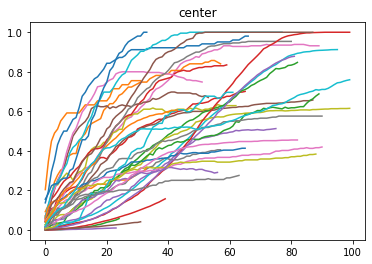

In [41]:
print(len(mselosses), len(mask_ovelaps_all))
mmm = [i for i in mselosses if len(i)>1]
lll = [i for i in mask_ovelaps_all if len(i)>1]
for i in lll:
    plt.plot(i)
last_perc = [i[-1] for i in lll]
print(np.median(last_perc))
plt.title('center');

40 40
0.1618071466329737


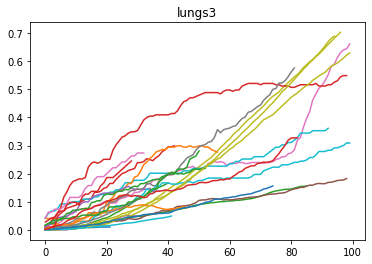

In [36]:
print(len(mselosses), len(mask_ovelaps_all))
mmm = [i for i in mselosses if len(i)>1]
lll = [i for i in mask_ovelaps_all if len(i)>1]
for i in lll:
    plt.plot(i)
last_perc = [i[-1] for i in lll]
print(np.median(last_perc))
plt.title('lungs3');

40 40


0.6429185547823273

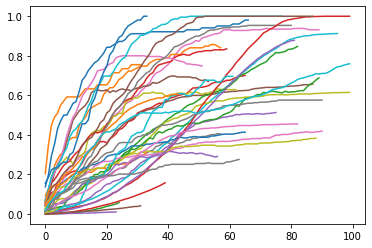

In [28]:
mselosses_bckp = mselosses
mask_ovelaps_all_bckp = mask_ovelaps_all
print(len(mselosses_bckp), len(mask_ovelaps_all_bckp))
mmm = [i for i in mselosses_bckp if len(i)>1]
lll = [i for i in mask_ovelaps_all_bckp if len(i)>1]
for i in lll:
    plt.plot(i)
last_perc = [i[-1] for i in lll]
np.median(last_perc)

(32, 32, 32)


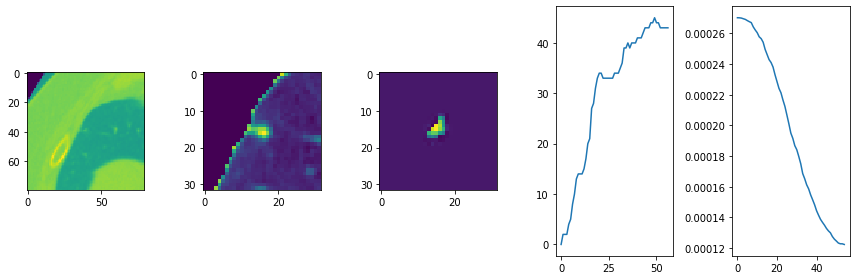

In [60]:
print(np.shape(img_gens[80]))
fig, ax = plt.subplots(1,5, figsize=(12,4))
ax[0].imshow(cube_augmented[39])
ax[1].imshow(orig32[16])
ax[2].imshow(img_gens[80][16])
ax[3].plot(mask_overlaps)
ax[4].plot(mseloss)
fig.tight_layout()

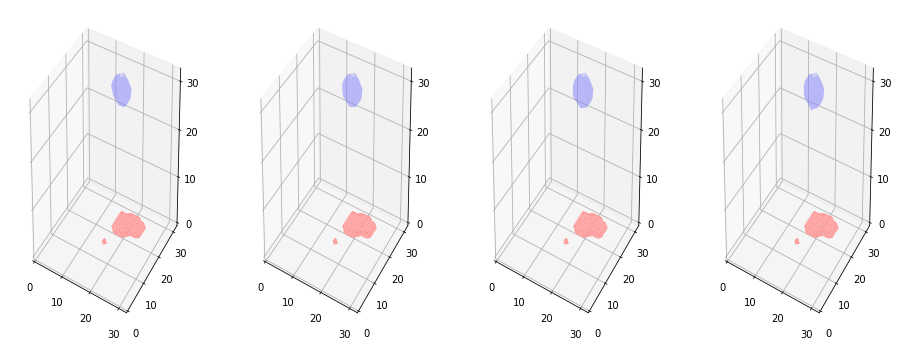

In [89]:
iii = center_automata_in_generation_in_mask(img_gens, mask32)
call_subplots(iii[30:35],[mm33, mm33,mm33,mm33], threshold=.1)

32

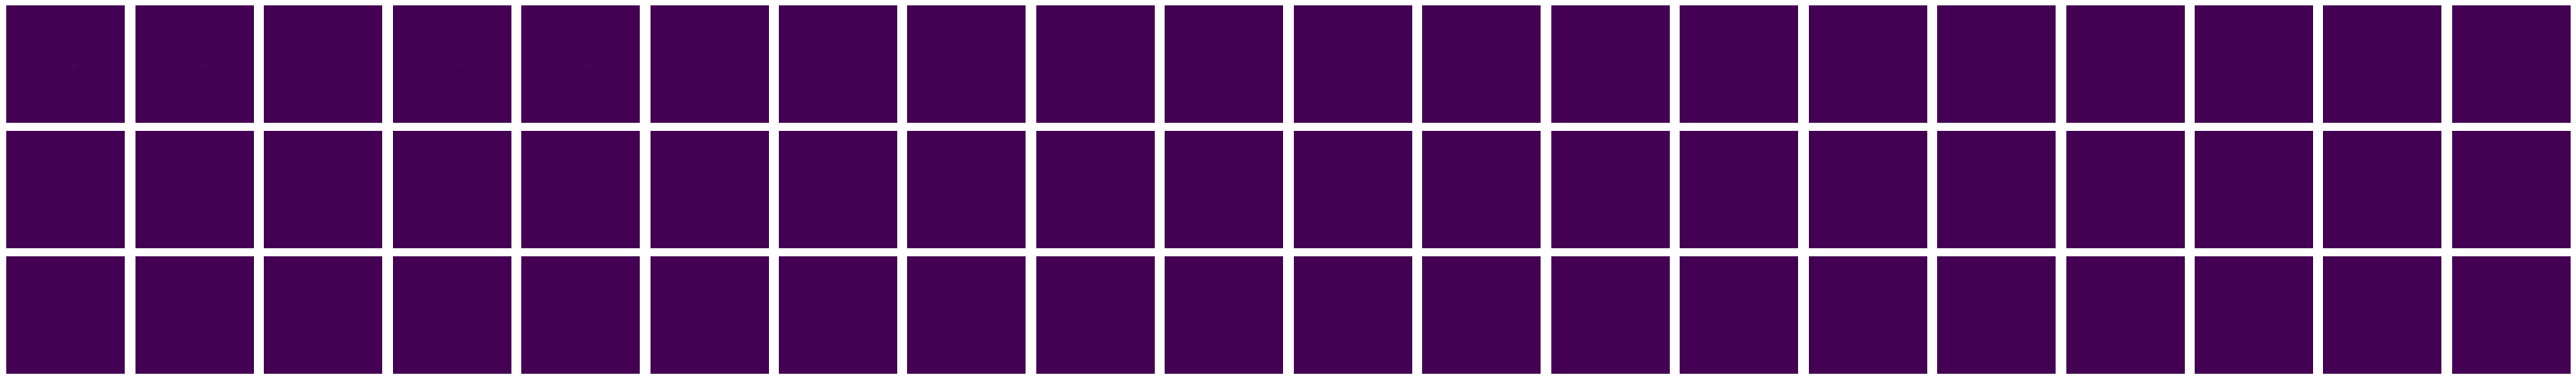

In [52]:
fig_multiple3D(img_gens[20:],r=3,c=20,name='nodules 1400')
len(mask_overlaps)

93 (32, 32, 32) (32, 32, 32) (32, 32, 32)


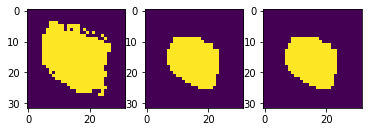

In [119]:
print(ca_gen, np.shape(mask_overlap),np.shape(img_gen>0),np.shape(mask32))
fig, ax = plt.subplots(1,3)
ax[0].imshow(img_gen[16]>0)
ax[1].imshow(mask32[16])
ax[2].imshow(mask_overlap[16])

In [59]:
!zip -qr gifs2_insert_gan_lungs3c2_centermask.zip gifs2 -x gifs2/images_before_gifs/**\* gifs2/check_alignment_from_patch_nodules_v2B_loop/**\*

In [58]:
print(path_dest)
ff_done = os.listdir(f'{path_dest}patched/subset1')
len(ff_done)
gifs_done = os.listdir(f'gifs2')
gifs_done = [i for i in gifs_done if '.gif' in i]
len(gifs_done)
# gifs_done

/data/OMM/project_results/Jun_17_2020_cell_aut_grown_nodules/batch_center/ca_nodules_generated_coord2_2comp/


40

In [52]:
for i in gifs_done:
    os.remove(f'gifs2/{i}')

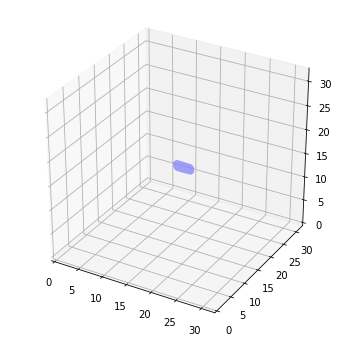

(None, 31)

In [51]:
plot_3d(img_gens[80], threshold=.1), ca_gen

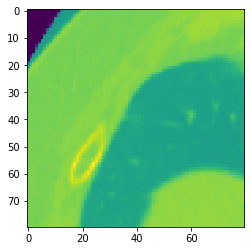

In [29]:
plt.imshow(cube_augmented[39])

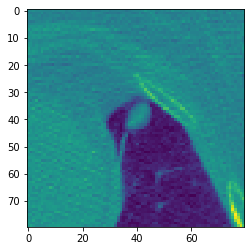

In [67]:
a = np.fromfile(f'{path_dest}patched/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143_block2_3210_z135y135x278_epD080',dtype='int16').astype('float32').reshape((80,80,80))
np.shape(a)
plt.imshow(a[39])

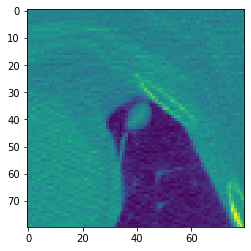

In [64]:
a = np.fromfile(f'{path_dest}patched/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143_block2_3210_z135y135x278_epD080',dtype='int16').astype('float32').reshape((80,80,80))
np.shape(a)
plt.imshow(a[39])

In [58]:
os.listdir(f'{path_dest}patched/subset1/')[-1]

'1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143_block2_3210_z135y135x278_epD020'

In [27]:
FILES[100]
np.where(np.asarray(FILES)=='1.3.6.1.4.1.14519.5.2.1.6279.6001.964952370561266624992539111877_block1_432_z249y132x130.raw.npz')

(array([10]),)

total_images_analyzed (in the subset of BATCH3) = 108


<Figure size 432x288 with 0 Axes>

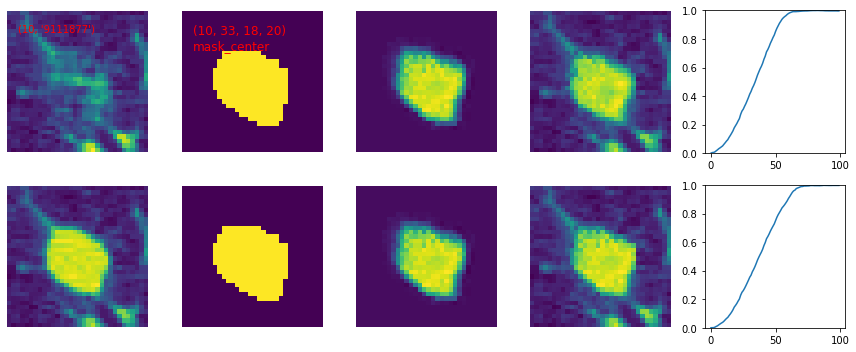

In [24]:
# From 1 image used in (BATCH3) get the corresponding inpain and orig
print(f'total_images_analyzed (in the subset of BATCH3) = {len(path_source)}')
# ids_chosen = [1, 12, 16, 18, 25, 27, 28, 30, 32, 37, 41, 43, 46, 47, 48, 51, 61, 71, 96, 103, 104, 109, 123]
ids_chosen = [i for i in range(19)]
FILES = os.listdir(path_source)
FILES = [i for i in FILES if '.npz' in i]
for idx, idx2name in enumerate(ids_chosen):
    if idx==10: #break
        name_correct = FILES[idx2name]
    #     print(name_correct)
        coords_ch = coords_centered[idx2name]
        zzz = int(np.median(coords_ch[0])); yyy = int(np.median(coords_ch[1])); xxx = int(np.median(coords_ch[2]))
        zz,yy,xx = zzz-0,yyy-0,xxx-0
        img_gen = np.load(f'{path_source}{name_correct}')
        img_gen = img_gen.f.arr_0
        # Get the images used in inpainting
        path_data = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/'
        last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
        last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
        mask_center = get_component_center(mask32)
        overlaps = [np.sum(np.logical_and(mask_center, (i>0).astype('float')))/np.sum(mask_center) for i in img_gen]
        img_gens_centered = center_automata_in_generation(img_gen)
        overlaps_cent = [np.sum(np.logical_and(mask_center, (i>0).astype('float')))/np.sum(mask_center) for i in img_gens_centered]
        # ===
        GEN=80
        plt.figure();
        fig, ax = plt.subplots(2,5,figsize=(12,5));
        ax[0,0].imshow(last32[16])
        ax[0,0].text(2,4,(idx, name_correct.split('_block')[0][-7:]), color='r')
        ax[1,0].imshow(orig32[16])
        ax[0,1].imshow(mask_center[16])
        ax[1,1].imshow(mask_center[16])
        ax[0,1].text(2,8,f'{idx,zz,yy,xx}\nmask_center',color='r',fontsize=12)
        mask_both = np.logical_and(mask_center,img_gen[GEN]>0.2) # MAYBE TRY 0.2
        mask_both_centered = np.logical_and(mask_center,img_gens_centered[GEN]>0.2)
        ax[0,2].imshow(img_gen[GEN][16])
        ax[0,2].imshow(img_gen[GEN][16]>0)
        ax[1,2].imshow(img_gens_centered[GEN][16])
        ax[0,2].imshow(img_gens_centered[GEN][16])
        ax[0,3].imshow(last32[16]*~mask_both[16]+img_gen[GEN][16]*mask_both[16])
        ax[1,3].imshow(last32[16]*~mask_both_centered[16]+img_gens_centered[GEN][16]*mask_both_centered[16])
        ax[0,4].plot(overlaps)
        ax[0,4].set_ylim([0,1])
        ax[1,4].plot(overlaps_cent)
        ax[1,4].set_ylim([0,1])
        for axx in ax.ravel()[[0,1,2,3,5,6,7,8]]: axx.axis('off'); plt.tight_layout() ;


ValueError: Surface level must be within volume data range.

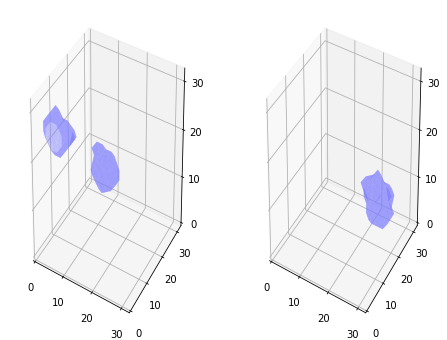

In [34]:
call_subplots([mask32, img_gen[80]>0, np.logical_and(mask32,img_gen[80]>0)], threshold=.1)

In [44]:
# MAIN BLOCK PATCH CA IMAGES BACKUP
SAVE_FIGS = 40
gen_range = np.arange(100)
FILES = os.listdir(path_source)
FILES = [i for i in FILES if '.npz' in i]
mselosses, min_losses, min_losses_idx, errors = [], [], [], []
path_data = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/' # Get the images used in inpainting
for idx, name_correct in tqdm_notebook(enumerate(FILES), total=len(FILES)):
    
    if idx==40: break
    
    # Get the images used in inpainting
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    # Read the NCA generated
    img_gens = np.load(f'{path_source}{name_correct}')
    img_gens = img_gens.f.arr_0
    # mask_ndl_grown = img_gens > 0
    
    mseloss = []
    min_loss = 1
    min_loss_one = []
    
    img_gens = center_automata_in_generation(img_gens) # WARNING: THIS IS THE (?) POSSIBLE NEW VERSION
    
    for ca_gen, img_gen in enumerate(img_gens):
        mask_overlap  = np.logical_and(img_gen>0, mask32)
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, img_gen)
       
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        # insert_gan_image_in_no_segmented_lungs3 was used for components > 1
#         numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs3(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) 
        if break_flag: break
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
            os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            name_correcr_modified = name_correct.split('.raw')[0]
            cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correcr_modified}_epD{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - img_gen*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

        # save a few ID for gif
        if idx % SAVE_FIGS > -1:
        # if idx % SAVE_FIGS == 0: #WARNING PUT THIS ONE BACK
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32, folder='gifs2/images_before_gifs/')
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
    fig_final_vs_cagen_vs_orig(cube_augmented, patched_corrected, orig32, name_correct, True, folder='gifs2/check_alignment_from_patch_nodules_v2B_loop/')
    
    if idx % SAVE_FIGS > -1:
    # if idx % SAVE_FIGS == 0: #WARNING PUT THIS ONE BACK
        fig_read_figs_and_make_gif2(name_correct, folder='gifs2/images_before_gifs/') # Make GIF

In [18]:
# USE IN THE VERSION WHERE COORDINATES ARE NEEDED
# Get the coords used to center the nodule using the name
assert 1==0
for idx, i in enumerate(names_centered):
    if i == name_correct.split('.npz')[0]:
        idx_coords = idx
        print(idx_coords, i)
print(f'zs = {zs[idx_coords]}, ys = {ys[idx_coords]}, xs = {xs[idx_coords]}')

401 1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957_block2_210_z170y208x245.raw
zs = 31, ys = 36, xs = 25


In [69]:
# load the file where you want to patch this image
# Read original CT image (not even segmented)
ndl_grown = img_gen[99]
mask_ndl_grown = ndl_grown > 0
numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
mask_overlap  = np.logical_and(mask_ndl_grown, mask32)
patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, ndl_grown)

# Insert generated image into original CT image,  (The coords of the nodule are in its name) 
numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)

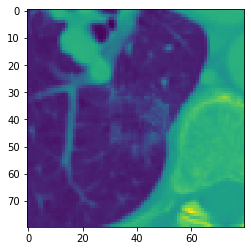

In [70]:
plt.imshow(cube_augmented[39])

In [26]:
path_dest, path_source

('/data/OMM/project_results/Jun_17_2020_cell_aut_grown_nodules/batch_center/ca_nodules_generated_center_2comp/',
 '/data/OMM/project_results/Jun_17_2020_cell_aut_grown_nodules/batch_center/ca_nodules_generated_center_2comp/',
 18)

In [42]:
# NEW
SAVE_FIGS = 40
gen_range = np.arange(100)
FILES = os.listdir(path_source)
FILES = [i for i in FILES if '.npz' in i]
mselosses, min_losses, min_losses_idx, errors = [], [], [], []
for idx, name_correct in tqdm_notebook(enumerate(FILES), total=len(FILES)):
    
    # Get the images used in inpainting
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    # Read the NCA generated
    img_gen = np.load(f'{path_source}{name_correct}')
    img_gen = img_gen.f.arr_0
    mask_ndl_grown = img_gen > 0
    # 
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    mseloss = []
    min_loss = 1
    min_loss_one = []
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, img_gen[ca_gen])
       
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        # insert_gan_image_in_no_segmented_lungs3 was used for components > 1
#         numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs3(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) 
        if break_flag: break
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
            os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            name_correcr_modified = name_correct.split('.raw')[0]
            cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correcr_modified}_epA{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - img_gen[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
    fig_final_vs_cagen_vs_orig(cube_augmented, patched_corrected, orig32, name_correct, True)
    
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF

KeyboardInterrupt: 

In [46]:
!ls /data/OMM/project_results/Jun_17_2020_cell_aut_grown_nodules/batch_center/ca_nodules_generated_center/patched

subset0  subset1  subset3  subset4  subset5  subset6  subset7  subset8	subset9


In [44]:
# load the file where you want to patch this image
# Read original CT image (not even segmented)
path_figs = 'figures_automata/'
for ii in tqdm_notebook(range(len(img_gen))):
    ndl_grown = img_gen[ii]
    mask_ndl_grown = ndl_grown > 0
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    mask_overlap  = np.logical_and(mask_ndl_grown, mask32)
    patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, ndl_grown)

    # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
    numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
    cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
    plt.imshow(cube_augmented[39])
    plt.axis('off')
    plt.savefig(f'{path_figs}nodule_{ii:03d}.jpg')
    plt.close()

In [45]:
files_figures = os.listdir(path_figs)
files_figures = [i for i in files_figures if '.jpg' in i]
files_figures = np.sort(files_figures)
images_all = []
for idx, i in enumerate(files_figures):
    
    one_fig = imageio.mimread(f'{path_figs}{i}')[0]
    os.remove(f'{path_figs}{i}')
    images_all.append(one_fig)
new_name = name_correct.split(".raw")[0]
imageio.mimsave(f'{path_figs}gifs/{new_name}.gif', images_all, duration=.1)

In [47]:
!ls -t figures_automata/gifs/

1.3.6.1.4.1.14519.5.2.1.6279.6001.222052723822248889877676736332_block1_0_z187y198x123.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.308655308958459380153492314021_block1_0_z182y225x107.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537301776672854630421_block1_10_z54y214x70.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.614147706162329660656328811671_block1_0_z171y267x157.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.955688628308192728558382581802_block2_642_z160y266x225.gif
1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074_block1_32_z199y114x196.gif


In [316]:
# NEW
SAVE_FIGS = 40
gen_range = np.arange(100)
fbatch3 = os.listdir(path_source)
fbatch3 = [i for i in fbatch3 if '.npz' in i]
mselosses, min_losses, min_losses_idx, errors = [], [], [], []
for idx, name_correct in tqdm_notebook(enumerate(fbatch3), total=len(fbatch3)):
    
    # Get the images used in inpainting
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    # Read the NCA generated
    img_gen = np.load(f'{path_source}{name_correct}')
    img_gen = img_gen.f.arr_0
    mask_ndl_grown = img_gen > 0
    # 
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    mseloss = []
    min_loss = 1
    min_loss_one = []
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, img_gen[ca_gen])
       
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs3(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
            os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            name_correcr_modified = name_correct.split('.raw')[0]
            cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correcr_modified}_ep{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - img_gen[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
    fig_final_vs_cagen_vs_orig(cube_augmented, patched_corrected, orig32, name_correct, True)
    
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF

In [314]:
name_correct.split('.raw')[0]

'1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143_block2_3210_z135y135x278'

In [313]:
print(name_correct)
print(name_correct[:-4])
print(name_correct.split('.raw')[0])

1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143_block2_3210_z135y135x278.raw.npz
1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143_block2_3210_z135y135x278.raw
1.3.6.1.4.1.14519.5.2.1.6279.6001.250397690690072950000431855143_block2_3210_z135y135x278


In [96]:
# OLD (March 9th morning)
SAVE_FIGS = 40
gen_range = np.arange(100)
fbatch3 = os.listdir(path_source)
mselosses, min_losses, min_losses_idx, errors = [], [], [], []
for idx, name_correct in enumerate(fbatch3):
    aaa=1
    if idx<aaa: continue
    if idx==aaa+1:break
    
    # Get the images used in inpainting
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    # Read the NCA generated
    img_gen = np.load(f'{path_source}{name_correct}')
    img_gen = img_gen.f.arr_0
    mask_ndl_grown = [i > 0 for i in ndl_grown]
    # 
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    mseloss = []
    min_loss = 1
    min_loss_one = []
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown, mask32)
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, img_gen[ca_gen])
       
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
            os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correct[:-4]}_ep{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - img_gen[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
    fig_final_vs_cagen_vs_orig(cube_augmented, patched_corrected, orig32, name_correct, True)
    
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF

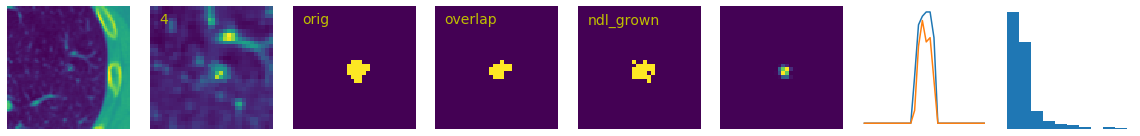

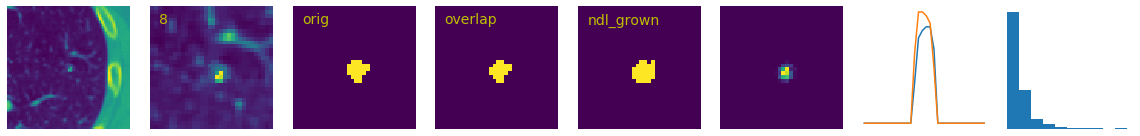

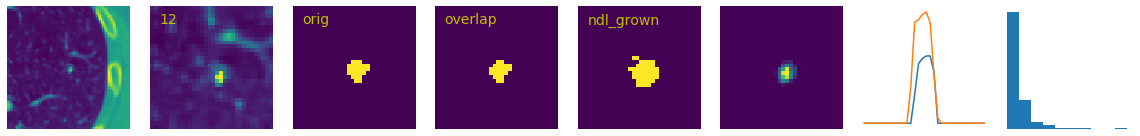

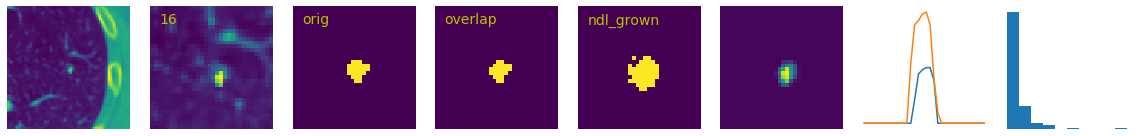

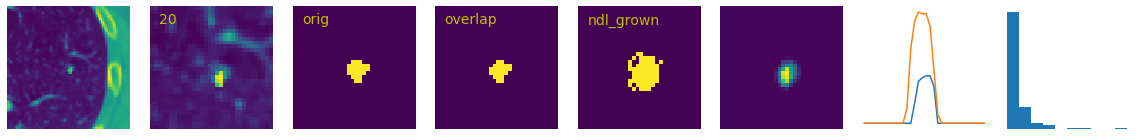

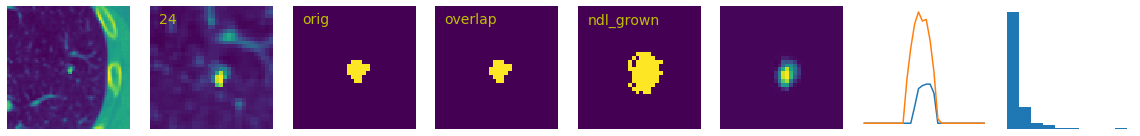

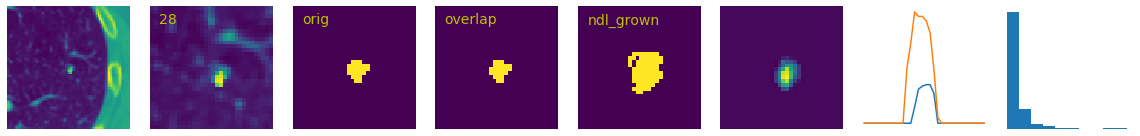

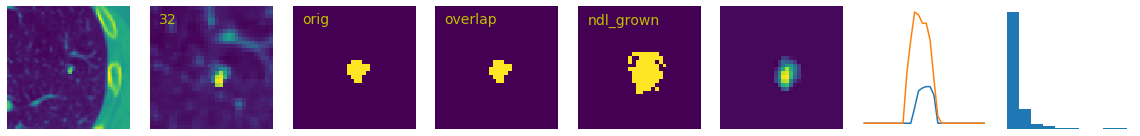

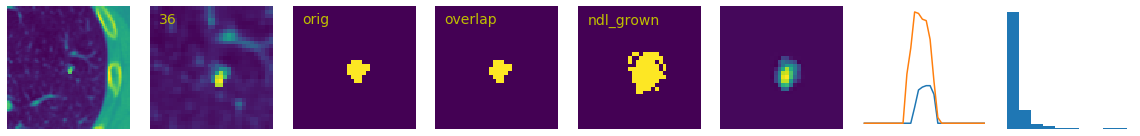

In [258]:
SAVE_FIGS = 40
gen_range = np.arange(100)
fbatch3 = os.listdir(path_source)
mselosses, min_losses, min_losses_idx, errors = [], [], [], []
for idx, name_correct in enumerate(fbatch3):
    aaa = 9
    if idx<aaa: continue
    if idx==aaa+1:break
    
    # Get the images used in inpainting
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct.split('.npz')[0])
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    # Read the NCA generated
    img_gen = np.load(f'{path_source}{name_correct}')
    img_gen = img_gen.f.arr_0
    mask_ndl_grown = img_gen > 0
    # 
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    mseloss = []
    min_loss = 1
    min_loss_one = []
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask2(mask_overlap, last32, img_gen[ca_gen])
       
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs3(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False: os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            if ca_gen % 4 ==0:
                fig_compare_masks_against_final_result(mask32, ca_gen, cube_augmented, mask_overlap, mask_ndl_grown, img_gen)
                
        loss_new = np.mean((orig32*mask32 - img_gen[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
    

In [252]:
ca_gen

37

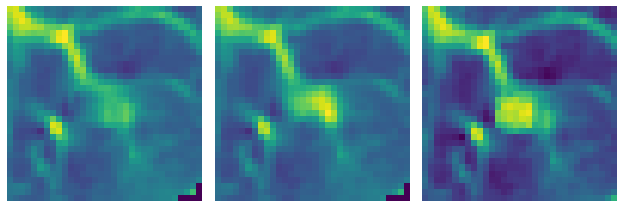

In [303]:
fig, ax = plt.subplots(1,3, figsize=(9,3))
ax[0].imshow(last32[15])
ax[1].imshow(orig32[15])
ax[2].imshow(cube_augmented[39][39-16: 39+16, 39-16: 39+16])
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [236]:
np.shape(numpyImage_resampled_inserted)

(352, 390, 390)

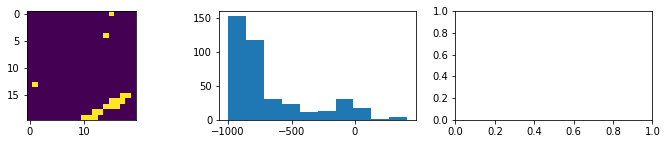

In [226]:
offset_ = 10
fig, ax = plt.subplots(1,3, figsize=(12,2))
ax[0].imshow(cube_augmented[39][39-offset_: 39+offset_, 39-offset_: 39+offset_])
ax[0].imshow(cube_augmented[39][39-offset_: 39+offset_, 39-offset_: 39+offset_]<=-960)
ax[1].hist(cube_augmented[39][39-offset_: 39+offset_, 39-offset_: 39+offset_].flatten());

In [234]:
print(np.shape(cube_augmented), 80**3, 6884**(1/3))
z_correction, y_correction, x_correction = np.where(cube_augmented < -960)

len(z_correction)

(80, 80, 80) 512000 19.02305603659917


6884

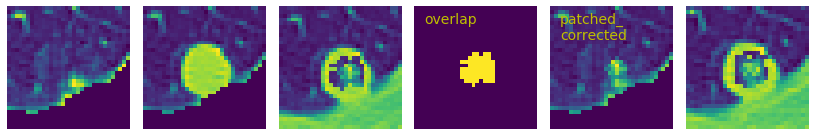

In [208]:
fig, ax = plt.subplots(1,6, figsize=(12,2))
ax[0].imshow(last32[15])
ax[1].imshow(orig32[15])
ax[2].imshow(cube_augmented[39][39-16: 39+16, 39-16: 39+16])
ax[3].imshow(mask_overlap[15])
ax[3].text(2,4,'overlap', fontsize=14, color = 'y')
ax[4].imshow(patched_corrected[15])
ax[4].text(2,8,'patched_\ncorrected', fontsize=14, color = 'y')
ax[5].imshow(numpyImage_resampled_inserted[coord_z][coord_y-15:coord_y+15, coord_x-15:coord_x+15])
# ax[5].text(2,6.5,'resampled_\ninserted', fontsize=14, color = 'y')
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask_overlap) # WARNING mask32 or mask_overlap?

In [57]:
def insert_gan_image_in_no_segmented_lungs3(image_patched_relevant, file_one, numpyImage_resampled, mask_correct):
    break_flag = False
    THRESHOLD_CORRECTION = -960
    '''1. the coords of the nodule are in its name.
    2. get a copy of the block around the nodule
    3. denormalize gan-created image and make sure its () similar to the resampled block 
    4. insert gan-created image (just the nodule mask) into the block
    5. put back the block (with the inserted gan-created nodule) into the copy of the resampled image'''
    size_half = 16
    # the coords of the nodule are in its name
    coord_z = int(file_one.split('_z')[-1].split('y')[0])
    coord_y = int(file_one.split('y')[-1].split('x')[0])
    coord_x = int(file_one.split('x')[-1].split('.')[0])
#     print(coord_z, coord_y, coord_x)
    # get a copy of the block around the nodule
    numpyImage_resampled_inserted = copy(numpyImage_resampled)
    numpyImage_resampled_block = numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half]
#     print(coord_z-size_half,coord_z+size_half, coord_y-size_half,coord_y+size_half, coord_x-size_half,coord_x+size_half)
#     print(np.shape(numpyImage_resampled_block))
    # denormalize gan-created image and make sure its () similar to the resampled block 
    image_patched_denorm = denormalizePatches(image_patched_relevant)
#     print(np.sum(numpyImage_resampled_block == image_patched_denorm))
    if np.sum(numpyImage_resampled_block == image_patched_denorm) < 1000:
        errors.append(file_one)
        break_flag = True
    # insert gan-created image (just the nodule mask) into the block
    zz,yy,xx = np.where(mask_correct==1)
    zz,yy,xx = np.where(image_patched_denorm > -960)
    numpyImage_resampled_block[zz,yy,xx] = image_patched_denorm[zz,yy,xx]
    # Correction v3
    z_correction, y_correction, x_correction = np.where(image_patched_denorm < THRESHOLD_CORRECTION)
    numpyImage_resampled_block[z_correction, y_correction, x_correction]
    
    # put back the block (with the inserted gan-created nodule) into the copy of the resampled image
    numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half] = numpyImage_resampled_block
    
#     zz_correction, yy_correction, xx_correction = np.where(numpyImage_resampled_inserted < -THRESHOLD_CORRECTION)
#     numpyImage_resampled_inserted[zz_correction, yy_correction, xx_correction] = numpyImage_resampled[zz_correction, yy_correction, xx_correction]
    
    return numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag

In [205]:
zz,yy,xx = np.where(mask_overlap==1)
print(zz[:10],yy[:10],xx[:10])
zz2 = zz + zs[idx_coords]-39; yy2 = yy + ys[idx_coords]-39; xx2 = xx + xs[idx_coords]-39;
print(zz2[:10],yy2[:10],xx2[:10])

[12 12 12 12 12 12 12 12 12 12] [13 13 14 14 14 15 15 15 16 16] [16 18 15 16 17 15 17 18 15 17]
[1 1 1 1 1 1 1 1 1 1] [ 8  8  9  9  9 10 10 10 11 11] [18 20 17 18 19 17 19 20 17 19]


(32, 32, 32)


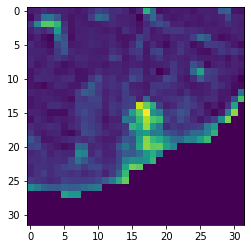

In [181]:
print(np.shape(patched_corrected))
plt.imshow(patched_corrected[15])

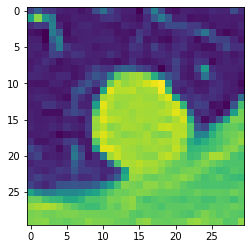

In [210]:
plt.imshow(numpyImage_resampled[coord_z][coord_y-15:coord_y+15, coord_x-15:coord_x+15])

In [145]:
for idx, i in enumerate(mask_ndl_grown):
    print(idx, np.sum(i))

0 17
1 54
2 103
3 138
4 184
5 263
6 329
7 396
8 466
9 543
10 637
11 713
12 796
13 915
14 1008
15 1109
16 1201
17 1281
18 1371
19 1447
20 1526
21 1600
22 1686
23 1776
24 1841
25 1936
26 2055
27 2161
28 2263
29 2363
30 2455
31 2566
32 2646
33 2724
34 2829
35 2909
36 2982
37 3054
38 3127
39 3211
40 3262
41 3314
42 3361
43 3407
44 3460
45 3500
46 3528
47 3562
48 3587
49 3614
50 3666
51 3692
52 3700
53 3714
54 3738
55 3747
56 3765
57 3775
58 3795
59 3803
60 3798
61 3784
62 3775
63 3765
64 3754
65 3753
66 3779
67 3765
68 3768
69 3769
70 3799
71 3812
72 3829
73 3856
74 3869
75 3884
76 3906
77 3927
78 3933
79 3950
80 3987
81 3994
82 4021
83 4038
84 4065
85 4110
86 4136
87 4190
88 4226
89 4260
90 4299
91 4345
92 4385
93 4434
94 4500
95 4557
96 4624
97 4692
98 4746
99 4810
100 4868
101 4932
102 4992
103 5057
104 5145
105 5187
106 5241
107 5309
108 5357
109 5435
110 5525
111 5595
112 5659
113 5734
114 5804
115 5859
116 5917
117 5982
118 6014
119 6056
120 6094
121 6128
122 6173
123 6204
124 6207
1

In [202]:
for idx, i in enumerate(names_centered):
    if i == name_correct.split('.npz')[0]:
        idx_coords = idx
        print(idx_coords, i)
print(f'zs = {zs[idx_coords]}, ys = {ys[idx_coords]}, xs = {xs[idx_coords]}')

600 1.3.6.1.4.1.14519.5.2.1.6279.6001.137773550852881583165286615668_block2_210_z202y102x240.raw
zs = 28, ys = 34, xs = 41


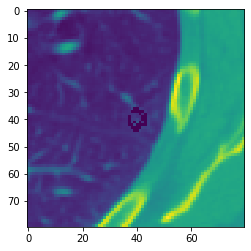

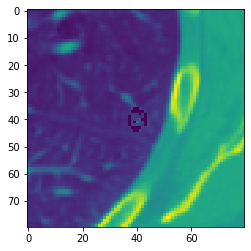

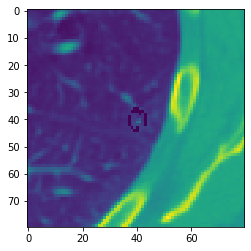

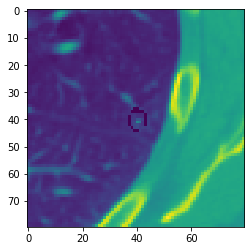

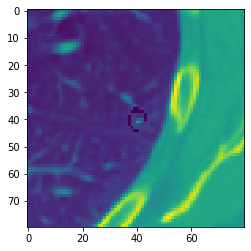

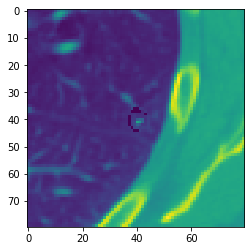

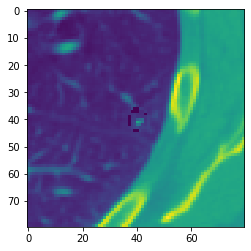

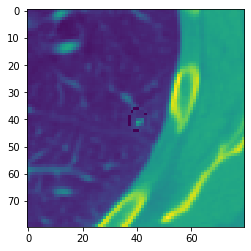

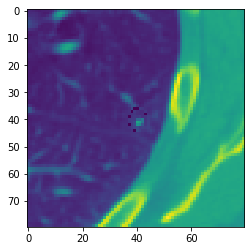

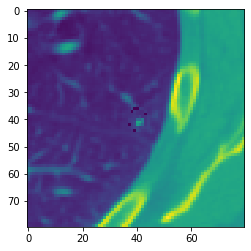

In [97]:
ppp = '/data/OMM/project results/Mar 02 20 - Cellular Automata Generated Images BATCH3/patched/subset7/'
ff = os.listdir(ppp)
ff= np.sort(ff)
for idx, i in enumerate(ff):
    a = np.fromfile(ppp+i,dtype='int16').astype('float32').reshape((80,80,80))
    if idx==10:break
    plt.figure()
    plt.imshow(a[39])

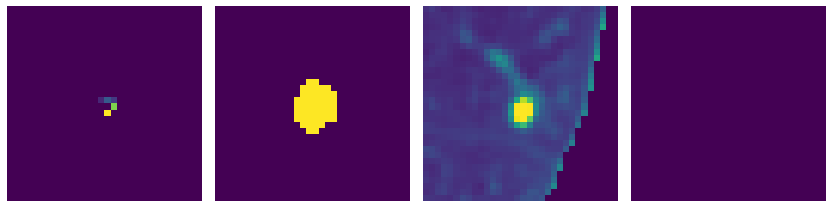

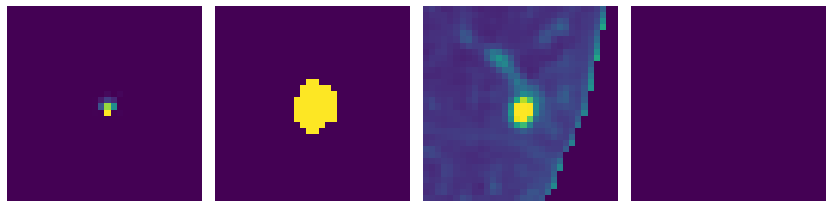

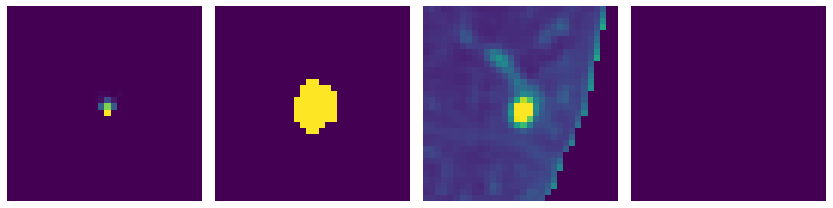

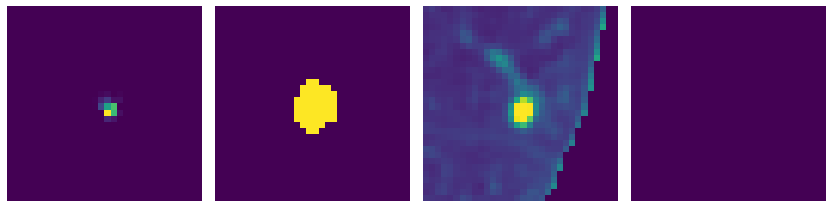

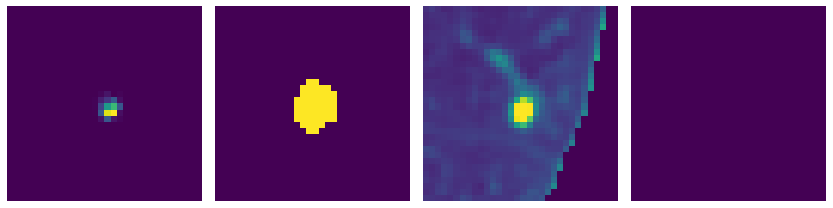

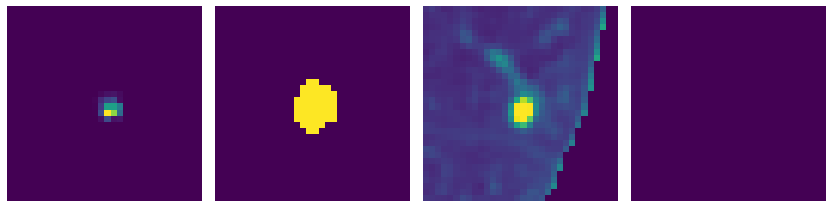

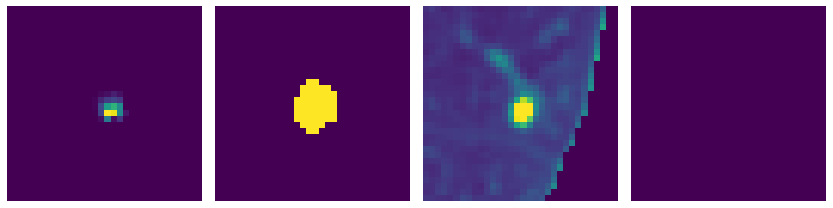

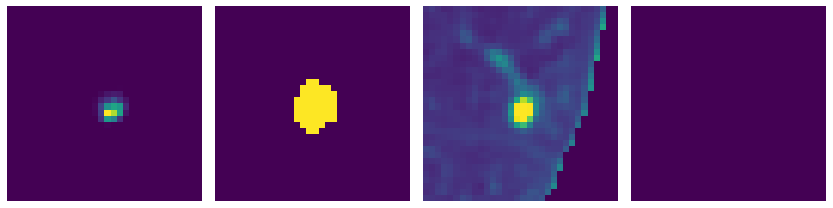

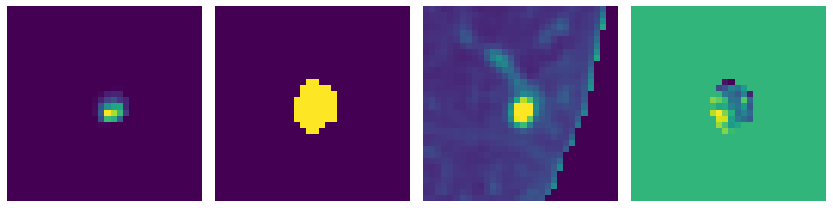

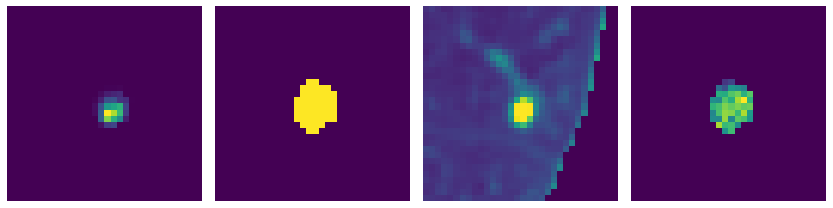

In [67]:
for idx, i in enumerate(img_gen):
    if idx==10: break
    fig, ax = plt.subplots(1,4, figsize=(12,3))
    ax[0].imshow(i[15])
    ax[1].imshow(mask32[15])
    ax[2].imshow(orig32[15])
    ax[3].imshow((ndl_grown[idx]*mask32)[15])
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

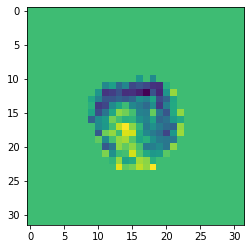

In [77]:
plt.imshow(ndl_grown[8])

In [78]:
np.shape(ndl_grown)

(32, 32, 32)

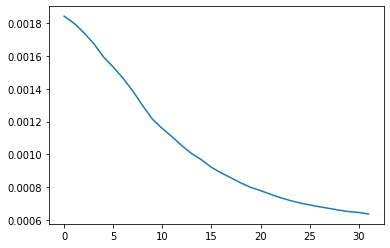

In [80]:
plt.plot(mseloss)

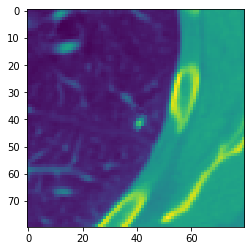

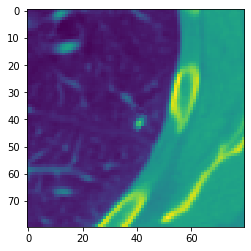

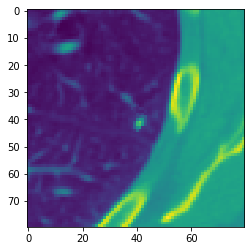

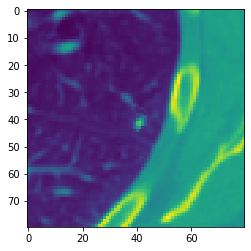

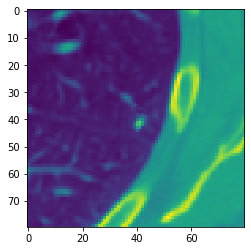

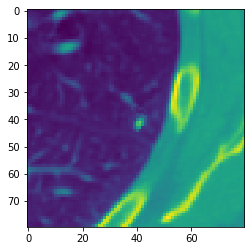

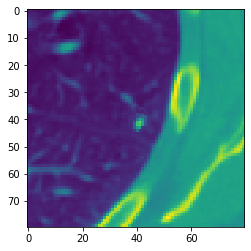

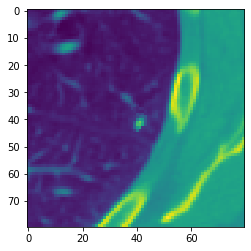

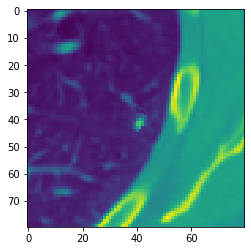

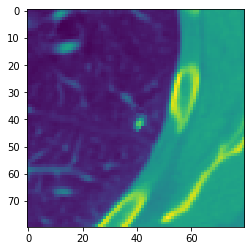

In [98]:
for idx, i in enumerate(ff[-10:]):
    a = np.fromfile(ppp+i,dtype='int16').astype('float32').reshape((80,80,80))
    if idx==10:break
    plt.figure()
    plt.imshow(a[39])

In [ ]:
# With correction
offset_ndl = 0
SAVE_FIGS = 40
gen_range = np.arange(100)
# gen_range = np.arange(20,200,3)
generations_multi = []
mselosses, min_losses, min_losses_idx = [], [], []
errors=[]
for idx, name_wrong in tqdm_notebook(enumerate(dict_names.keys()), total=len(dict_names.keys())):
    if idx<offset_ndl: continue
#     if idx==offset_ndl+1: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    
    mseloss = []
    min_loss = 1
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen)
        
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        # padd resampled image (some nodules are close to border) 
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
            os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correct[:-4]}_ep{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - ndl_grown[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
        
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF

## 3. Fixing an error with the names given to the automata output

In [21]:
# Previously we were getting the nodules where label_nr == 1 BUT we were not making any modification
# to files_sorted. Now we also modify that variable -> files_sorted_centered
nodules_smaller = files_ndls_sorted[:,16:-16, 16:-16, 16:-16]
print(len(files_sorted), len(files_ndls_sorted), np.shape(nodules_smaller[0]))
nodules_centered = []
files_sorted_centered, files_excluded = [], []
for idx, i in enumerate(nodules_smaller):
    labelled, nr = label(i)
    if nr == 1: 
        nodules_centered.append(i)
        files_sorted_centered.append(files_sorted[idx]) # <-- this line was not included
    else:
        files_excluded.append(files_sorted[idx])
nodules_smaller2 = np.expand_dims(nodules_centered,1)
print(len(nodules_smaller2), len(files_sorted_centered), np.shape(nodules_smaller2[0]))
# 3D versions
nodules3D = [np.swapaxes(i,0,1) for i in nodules_smaller2]
nodules3D = [np.swapaxes(i,1,2) for i in nodules3D]
nodules3D = [np.swapaxes(i,2,3) for i in nodules3D]
# fig_multiple3D(nodules3D[1610:],r=4,c=4,name='nodules 1400')

2292 2292 (32, 32, 32)
1657 1657 (1, 32, 32, 32)


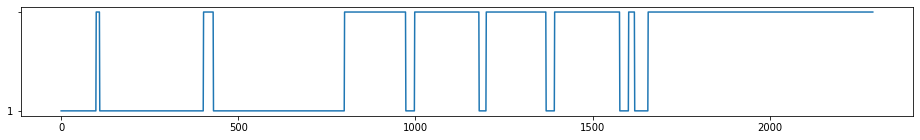

In [22]:
# 1. Track back the nodules that were already grown
# First get the indices of the nodules that were already grown by the celullar automata.
# Those indices are from the list constructed with only those nodules where (label_nr == 1).
# When that list was constructed a separate list with their corresponding names was not constructed, and
# the grown files are getting an INCORRECT name from the list with ALL names
files_sorted2_zeros = np.zeros_like(files_sorted)
idx_ndl_grown = []
for idx, i in enumerate(files_sorted):
    if i in files_done:
        idx_ndl_grown.append(idx)
files_sorted2_zeros[np.asarray(idx_ndl_grown)] = 1
plt.figure(figsize=(16,2))
plt.plot(files_sorted2_zeros);

In [23]:
# 1.5 We might need to center back the nodule
# When the only-nodules dataset was created we centered the nodule using
# z_min, y_min, x_min, z_max, y_max, x_max, z_len, y_len, x_len. x_min and x_max are the min and max coord of the
# nodule in one axis. amd x_len is the length of the nodule in that axis
zyx = np.load('zyx_min_max_len_sorted.npy')

2292 894 894


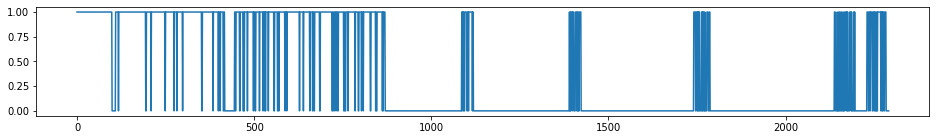

In [24]:
# Track back the nodules that were already grown
# 2. We can use those indices to trace back the correct name of grown nodules.
files_sorted2_zeros = np.squeeze(np.zeros((1,len(files_sorted))))
idx_ndl_traced_back = []
names_correct = []
zyx_correct = []
for idx, i in enumerate(files_sorted):
    if i in np.asarray(files_sorted_centered)[idx_ndl_grown]:
        idx_ndl_traced_back.append(idx)
        names_correct.append(i)
        zyx_correct.append(zyx[idx])
files_sorted2_zeros[np.asarray(idx_ndl_traced_back)] = 1
plt.figure(figsize=(16,2))
plt.plot(files_sorted2_zeros);
print(len(files_sorted), len(idx_ndl_traced_back), len(zyx_correct))

2292 840 840


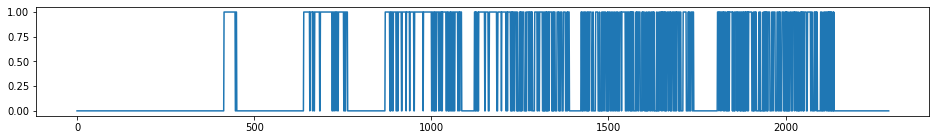

In [14]:
# Track back the nodules that were already grown
# 2. We can use those indices to trace back the correct name of grown nodules.
files_sorted2_zeros = np.squeeze(np.zeros((1,len(files_sorted))))
idx_ndl_traced_back = []
names_correct = []
zyx_correct = []
for idx, i in enumerate(files_sorted):
    if i in np.asarray(files_sorted_centered)[idx_ndl_grown]:
        idx_ndl_traced_back.append(idx)
        names_correct.append(i)
        zyx_correct.append(zyx[idx])
files_sorted2_zeros[np.asarray(idx_ndl_traced_back)] = 1
plt.figure(figsize=(16,2))
plt.plot(files_sorted2_zeros);
print(len(files_sorted), len(idx_ndl_traced_back), len(zyx_correct))

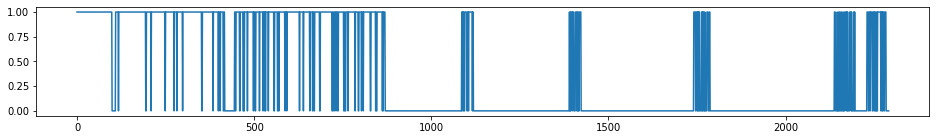

In [25]:
plt.figure(figsize=(16,2))
plt.plot(files_sorted2_zeros);

In [38]:
len(files_done)

894

In [26]:
# 3. Make a dictionary that maps the incorrect to the correct name
dict_names = dict(zip(files_done, names_correct))
dict_zyx = dict(zip(files_done, zyx_correct))
name_wrong = files_done[-1]
name_correct = dict_names.get(name_wrong)
name_correct_zyx = dict_zyx.get(name_wrong)
print(name_wrong) # OLD (incorrect)
print(name_correct) # NEW (correct)
print(name_correct_zyx)

1.3.6.1.4.1.14519.5.2.1.6279.6001.202643836890896697853521610450_block1_0_z212y144x66.raw
1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_block2_432_z229y296x280.raw
[15 14 15 51 48 52 37 35 38]


## 4. Fix some dark spots visible in the patched image.

In [27]:
def patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen):
    '''We patch the celullar-automata-generated (augen) nodule into the inpainted image (inpain)
    The extra mask (part2 < part5) is used to fix some dark spots visible in the patched image.
    This mask is formed by the values that are larger in the inpainted image than in the ca-generated
    image (looking only into the nodule-generated region)'''
    part1 = ((~mask_overlap).astype(int)*last32)
    part2 = ((mask_overlap).astype(int)*ndl_grown[ca_gen])
    part3 = (((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen]))
    part4 = part2 > 0
    part5 = last32 * part4
    part6 = part2 < part5
    part7 = part2 < orig32*part4
    part8 = part2*(~part6) + last32*part6
    part9 = part2*(~part6) + last32*part6 + part1*(~part4)
    return part9, part4

In [29]:
path_data = '/data/OMM/Datasets/LIDC_other_formats/LUNA_inpainted_cubes_for_GAN_v2/'
files = os.listdir(f'{path_data}original/')
print(f'total files = {len(files)}')
print(name_correct)

total files = 2292
1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_block2_432_z229y296x280.raw


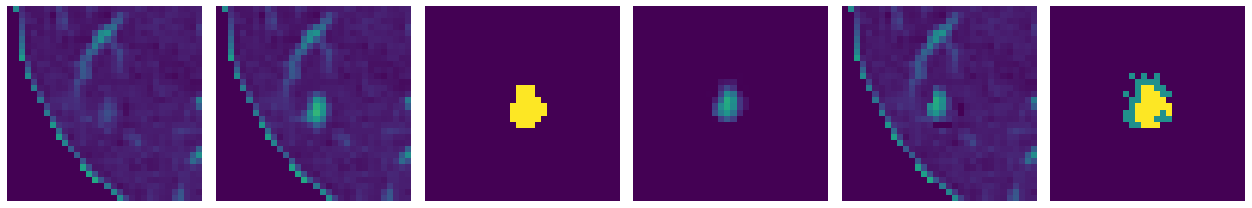

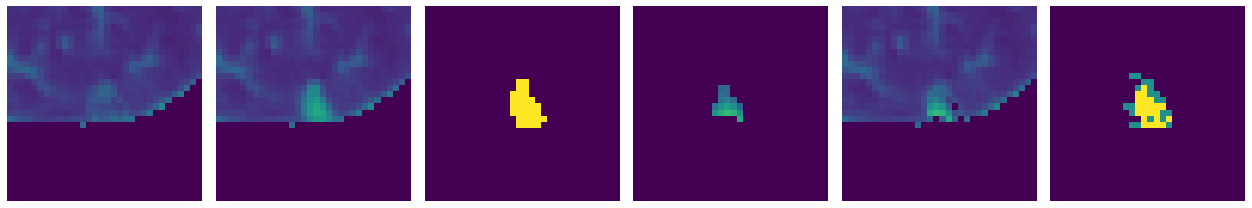

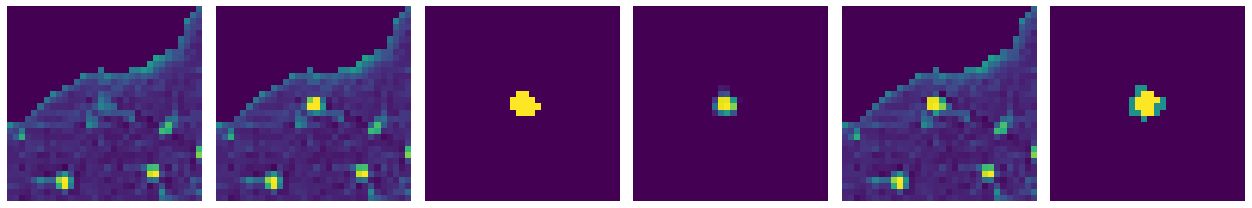

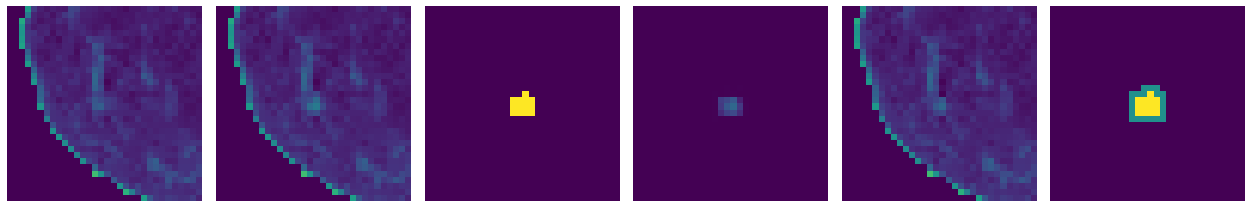

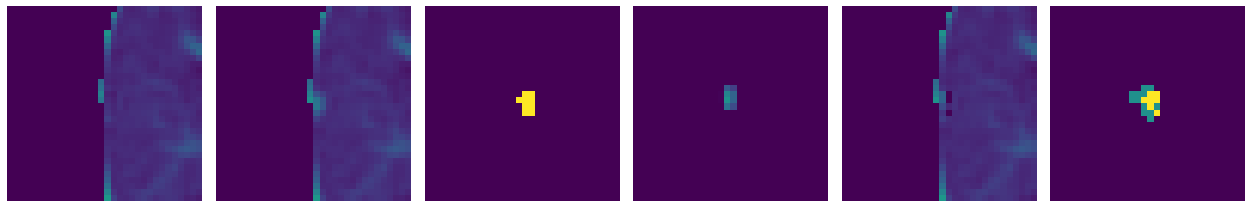

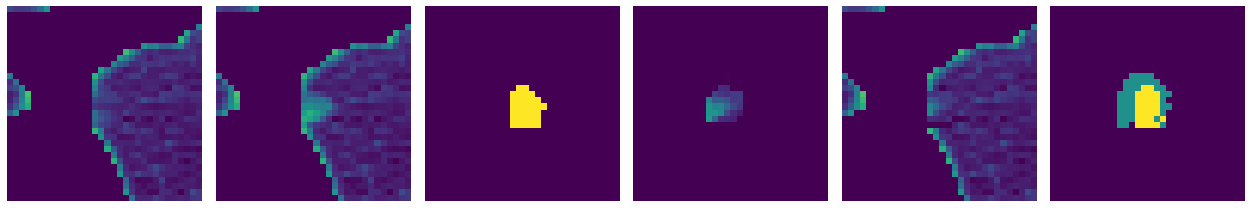

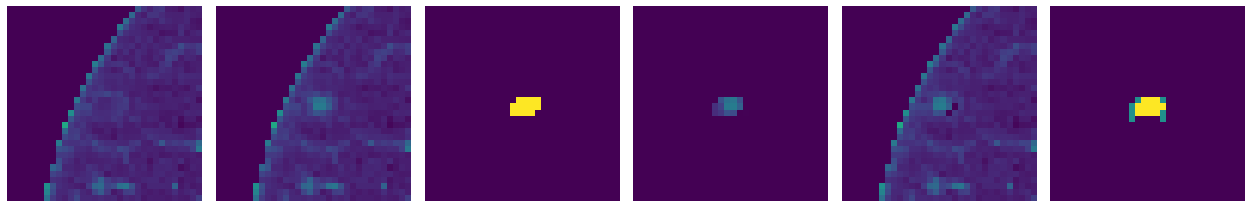

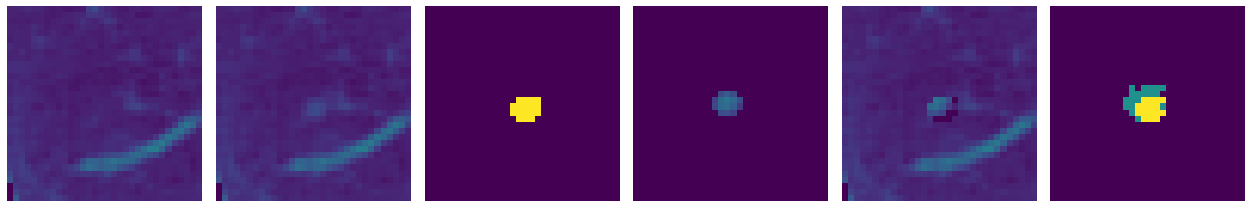

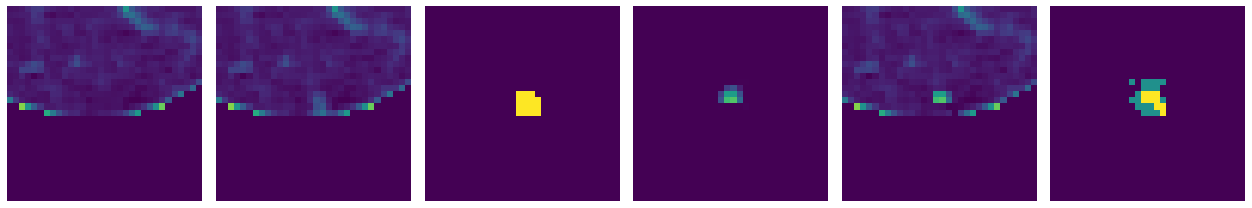

In [30]:
# Without correction
offset_ndl = 200
ca_gen = 50
for idx, name_wrong in enumerate(dict_names.keys()):
    if idx<=offset_ndl: continue
    if idx==offset_ndl+10: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
    patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
    fig, ax = plt.subplots(1,6, figsize=(18,3));
    ax[0].imshow(last32[15], vmin=0, vmax=1); 
    ax[1].imshow(orig32[15], vmin=0, vmax=1); 
    ax[2].imshow(mask32[15], vmin=0, vmax=1)
    ax[3].imshow(ndl_grown[ca_gen][15], vmin=0, vmax=1)
    ax[4].imshow(patched[15], vmin=0, vmax=1)
    ax[5].imshow(mask_ndl_grown[ca_gen][15] + mask32[15], vmin=0, vmax=2)
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

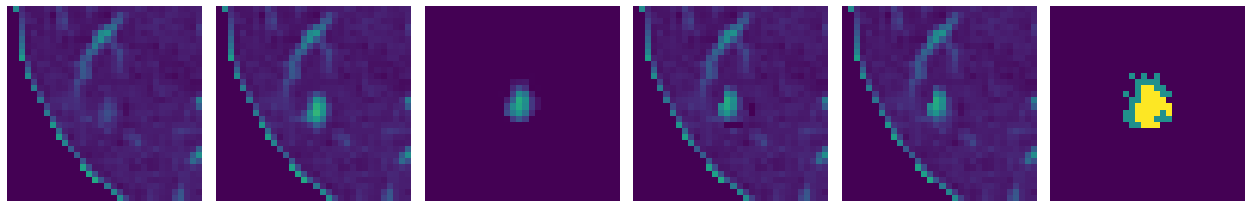

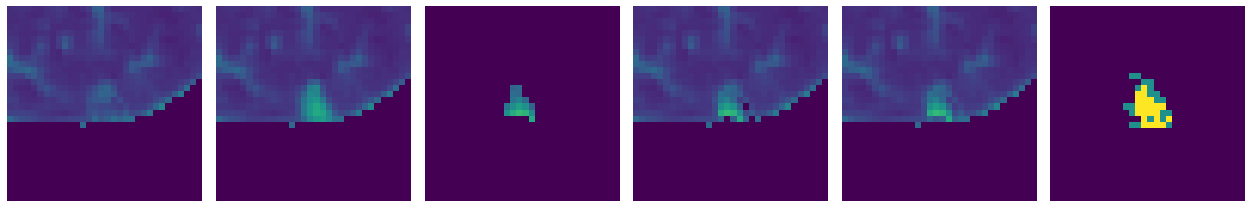

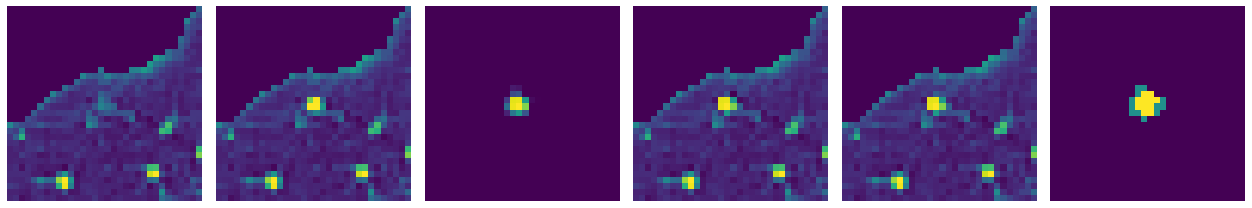

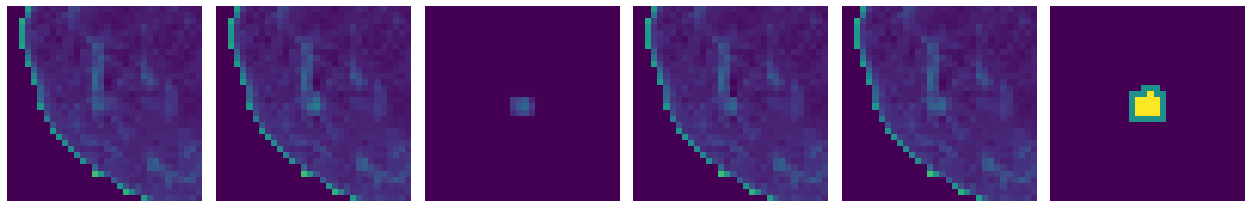

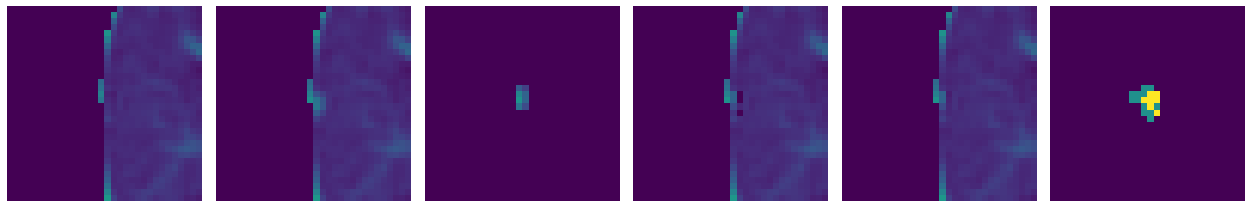

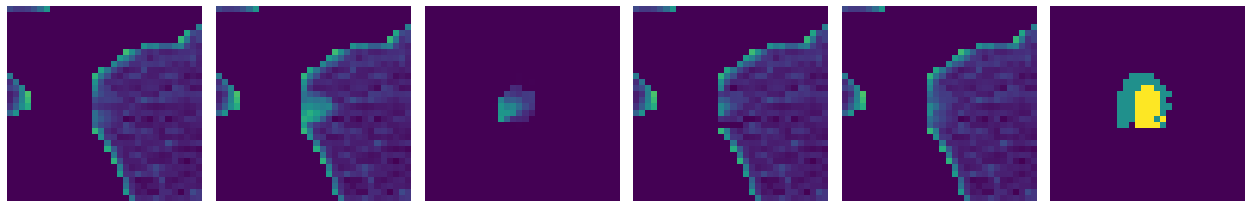

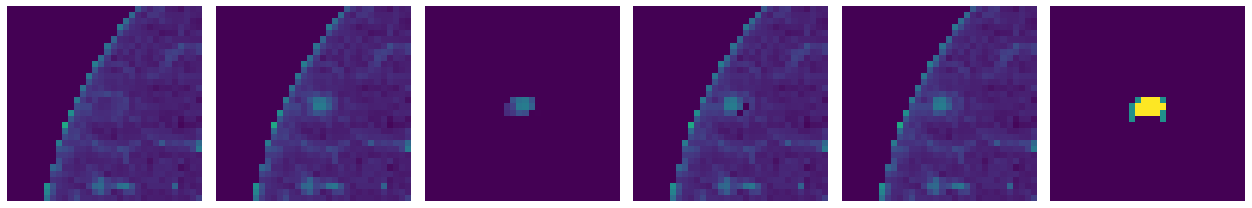

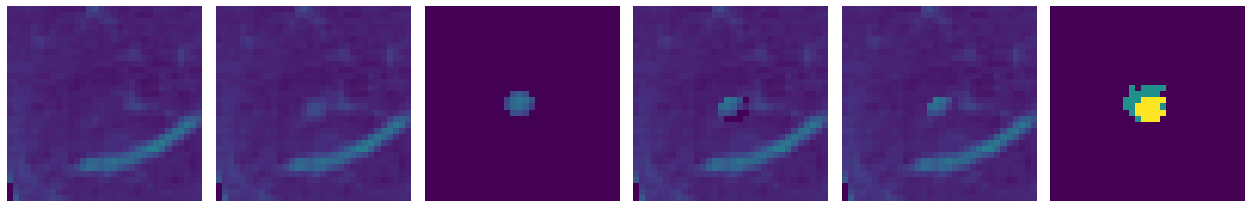

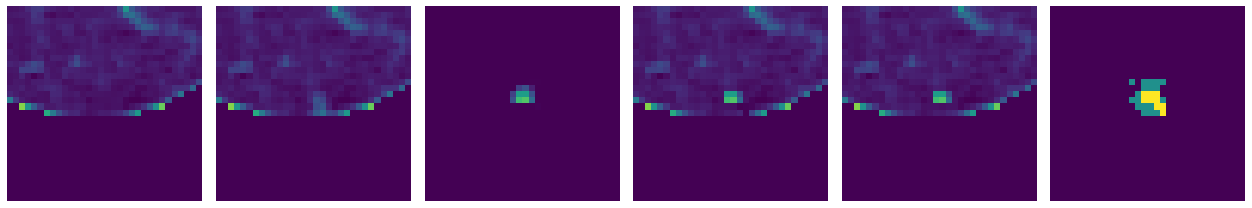

In [31]:
# With correction
offset_ndl = 200
ca_gen = 50
for idx, name_wrong in enumerate(dict_names.keys()):
    if idx<=offset_ndl: continue
    if idx==offset_ndl+10: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
    patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
    patched_corrected, _ = patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen)
    fig, ax = plt.subplots(1,6, figsize=(18,3));
    ax[0].imshow(last32[15], vmin=0, vmax=1); 
    ax[1].imshow(orig32[15], vmin=0, vmax=1); 
#     ax[2].imshow(mask32[15], vmin=0, vmax=1)
    ax[2].imshow(ndl_grown[ca_gen][15], vmin=0, vmax=1)
    ax[3].imshow(patched[15], vmin=0, vmax=1)
    ax[4].imshow(patched_corrected[15], vmin=0, vmax=1)
    ax[5].imshow(mask_ndl_grown[ca_gen][15] + mask32[15], vmin=0, vmax=2)
    
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

# 5. Patch the nodule grown with celullar automata in the inpainted image  

In [32]:
def find_no_segmented_subfolder_and_read_it(file_one, data_candidates):
    '''find the corresponding subfolder of this image, read it and resample it'''
    # find the corresponding subfolder of this image
    name_original = file_one.split('_')[0] + '.mhd'
    data_dir_subsets = os.listdir(data_candidates)
    data_dir_subsets = [i for i in data_dir_subsets if 'subset' in i]
    data_dir_subsets = np.sort(data_dir_subsets)
    for sub in data_dir_subsets:
        if name_original in os.listdir(f'{data_candidates}{sub}'):
            break
    #read original (no-segmented) image
    numpyImage, numpyOrigin, numpySpacing = load_itk_image(f'{data_candidates}{sub}/{name_original}')
    # resample the image_without_segmentation
    new_spacing = [1,1,1]
    numpyImage_shape = ((np.shape(numpyImage) * numpySpacing) / np.asarray(new_spacing)).astype(int)
    numpyImage_resampled = resample_scan_sitk(numpyImage, numpySpacing, numpyImage_shape, new_spacing=new_spacing)
    return numpyImage_resampled, sub

In [56]:
for aaa in range(5):
    for bbb in np.arange(5):
        if bbb==2:break
        print(aaa, bbb)
        

0 0
0 1
1 0
1 1
2 0
2 1
3 0
3 1
4 0
4 1


In [63]:
# With correction
offset_ndl = 0
SAVE_FIGS = 40
gen_range = np.arange(100)
# gen_range = np.arange(20,200,3)
generations_multi = []
mselosses, min_losses, min_losses_idx = [], [], []
errors=[]
for idx, name_wrong in tqdm_notebook(enumerate(dict_names.keys()), total=len(dict_names.keys())):
    if idx<offset_ndl: continue
#     if idx==offset_ndl+1: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    
    mseloss = []
    min_loss = 1
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen)
        
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        # padd resampled image (some nodules are close to border) 
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
        if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
            os.makedirs(f'{path_dest}patched/{subfolder_save}')
        if ca_gen >= 2: #skip first two generations
            cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correct[:-4]}_ep{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - ndl_grown[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 

        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
        
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF

/home/om18/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [66]:
path_dest = '/data/OMM/project results/Mar 02 20 - Cellular Automata Generated ImagesDELETE/'

In [ ]:
# With correction
offset_ndl = 0
SAVE_FIGS = 40
gen_range = np.arange(100)
# gen_range = np.arange(20,200,3)
generations_multi = []
mselosses, min_losses, min_losses_idx = [], [], []
errors=[]
for idx, name_wrong in tqdm_notebook(enumerate(dict_names.keys()), total=len(dict_names.keys())):
    if idx<offset_ndl: continue
#     if idx==offset_ndl+1: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    
    # Read original CT image (not even segmented)
    numpyImage_resampled, subfolder_save = find_no_segmented_subfolder_and_read_it(name_correct, path_candidates)
    
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    
    mseloss = []
    min_loss = 1
    
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen)
        
        # Insert generated image into original CT image,  (The coords of the nodule are in its name) 
        numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag = insert_gan_image_in_no_segmented_lungs2(patched_corrected, name_correct, numpyImage_resampled, mask32) # WARNING mask32 or mask_overlap?
        if break_flag: break
        # padd resampled image (some nodules are close to border) 
        cube_augmented = pad_image_and_get_right_size_cube(numpyImage_resampled_inserted, coord_z, coord_y, coord_x)
        
        # save augmented data
#         if os.path.isdir(f'{path_dest}patched/{subfolder_save}') == False:
#             os.makedirs(f'{path_dest}patched/{subfolder_save}')
#         if ca_gen >= 2: #skip first two generations
#             cube_augmented.tofile(f'{path_dest}patched/{subfolder_save}/{name_correct[:-4]}_ep{ca_gen:03d}')
        
        loss_new = np.mean((orig32*mask32 - ndl_grown[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
#         mseloss.append(loss_new) 

        # save a few ID for gif
#         if idx % SAVE_FIGS == 0:
#             fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
#     min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
        
#     if idx % SAVE_FIGS == 0:
#         fig_read_figs_and_make_gif(name_correct) # Make GIF

In [62]:
def insert_gan_image_in_no_segmented_lungs2(image_patched_relevant, file_one, numpyImage_resampled, mask_correct):
    break_flag = False
    '''1. the coords of the nodule are in its name.
    2. get a copy of the block around the nodule
    3. denormalize gan-created image and make sure its () similar to the resampled block 
    4. insert gan-created image (just the nodule mask) into the block
    5. put back the block (with the inserted gan-created nodule) into the copy of the resampled image'''
    size_half = 16
    # the coords of the nodule are in its name
    coord_z = int(file_one.split('_z')[-1].split('y')[0])
    coord_y = int(file_one.split('y')[-1].split('x')[0])
    coord_x = int(file_one.split('x')[-1].split('.')[0])
#     print(coord_z, coord_y, coord_x)
    # get a copy of the block around the nodule
    numpyImage_resampled_inserted = copy(numpyImage_resampled)
    numpyImage_resampled_block = numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half]
#     print(coord_z-size_half,coord_z+size_half, coord_y-size_half,coord_y+size_half, coord_x-size_half,coord_x+size_half)
#     print(np.shape(numpyImage_resampled_block))
    # denormalize gan-created image and make sure its () similar to the resampled block 
    image_patched_denorm = denormalizePatches(image_patched_relevant)
#     print(np.sum(numpyImage_resampled_block == image_patched_denorm))
    if np.sum(numpyImage_resampled_block == image_patched_denorm) < 1000:
        errors.append(file_one)
        break_flag = True
    # insert gan-created image (just the nodule mask) into the block
    zz,yy,xx = np.where(mask_correct==1)
    numpyImage_resampled_block[zz,yy,xx] = image_patched_denorm[zz,yy,xx]
    # put back the block (with the inserted gan-created nodule) into the copy of the resampled image
    numpyImage_resampled_inserted[coord_z-size_half:coord_z+size_half, coord_y-size_half:coord_y+size_half, coord_x-size_half:coord_x+size_half] = numpyImage_resampled_block
    return numpyImage_resampled_inserted, coord_z, coord_y, coord_x, break_flag

In [52]:
238-206, 241-209, 218-186 

(32, 32, 32)

In [37]:
len(dict_names.keys())

894

(32, 32, 32)



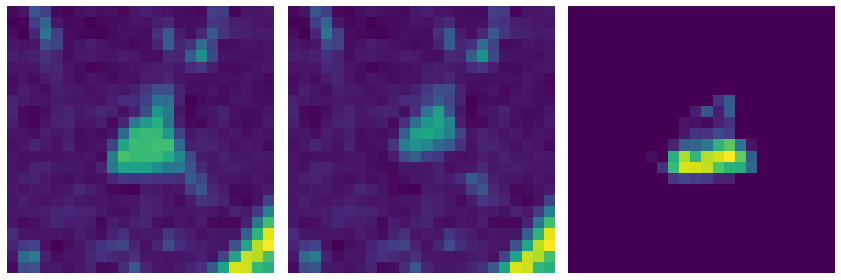

In [96]:
padxx = 12
print(np.shape(patched_corrected))
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(numpyImage_resampled[coord_z][coord_y-padxx:coord_y+padxx, coord_x-padxx:coord_x+padxx])
ax[1].imshow(numpyImage_resampled_inserted[coord_z][coord_y-padxx:coord_y+padxx, coord_x-padxx:coord_x+padxx])
ax[2].imshow(np.abs(numpyImage_resampled[coord_z][coord_y-padxx:coord_y+padxx, coord_x-padxx:coord_x+padxx] - numpyImage_resampled_inserted[coord_z][coord_y-padxx:coord_y+padxx, coord_x-padxx:coord_x+padxx]))
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [128]:
import sys

128
128
128
128
128
128
128
128
128
128


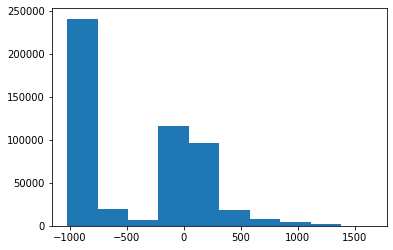

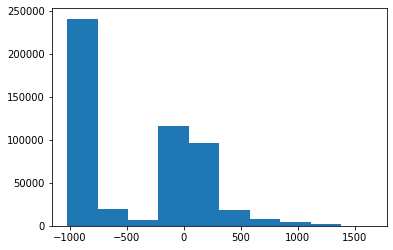

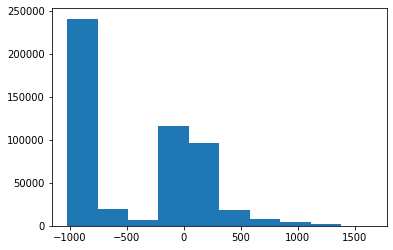

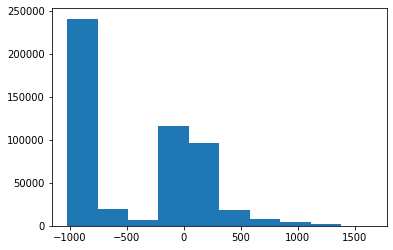

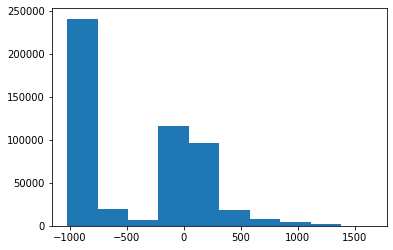

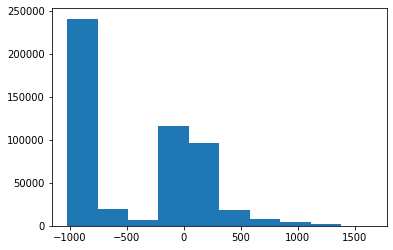

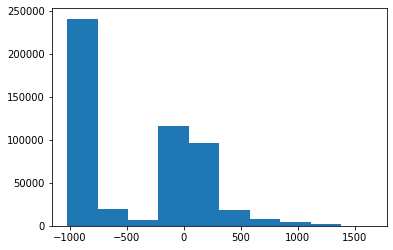

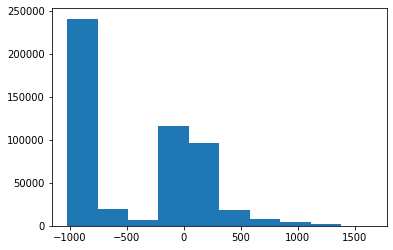

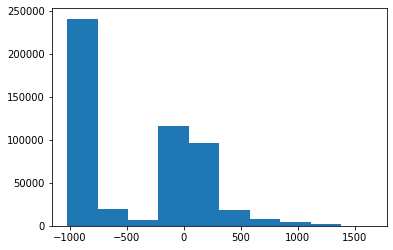

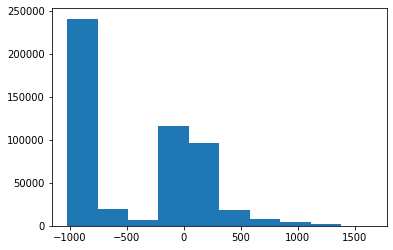

In [129]:
path_xx = '/data/OMM/project results/Mar 02 20 - Cellular Automata Generated Images/patched/subset5/'
ff = os.listdir(path_xx)
ff = np.sort(ff)
for idx, i in enumerate(ff):
    if idx==10:break
    a = np.fromfile(f'{path_xx}{i}',dtype='int16').astype('float32').reshape((80,80,80))
    print(sys.getsizeof(a))
    plt.figure()
    plt.hist(a.flatten());

In [124]:
a = np.fromfile(f'{pathxx}{i}',dtype='float').astype('float32').reshape((80,80,80))

ValueError: cannot reshape array of size 126400 into shape (80,80,80)

128
128
128
128
128
128
128
128
128
128


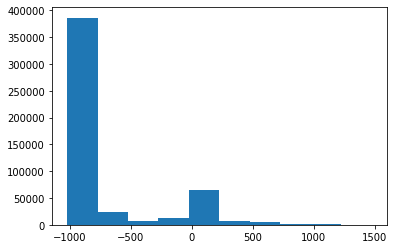

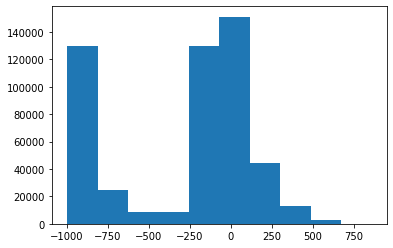

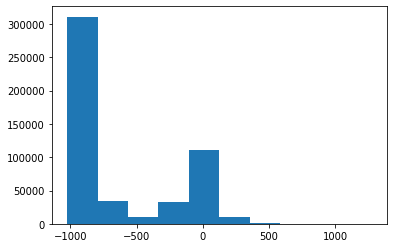

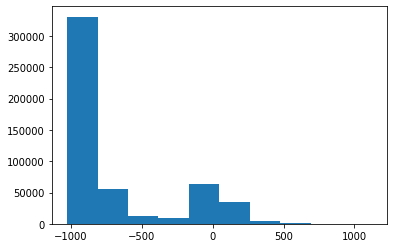

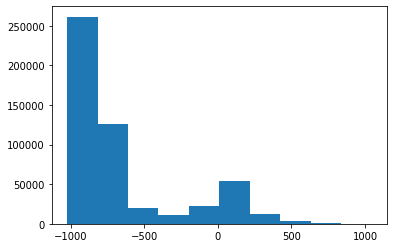

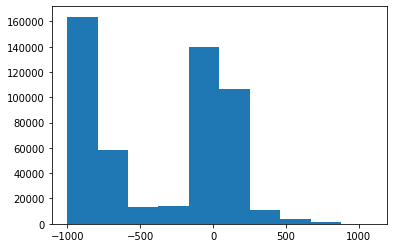

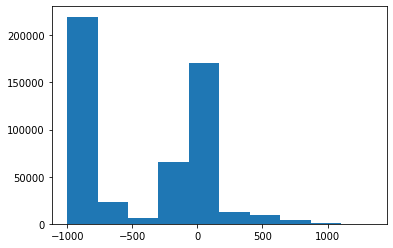

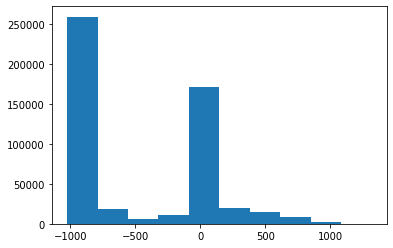

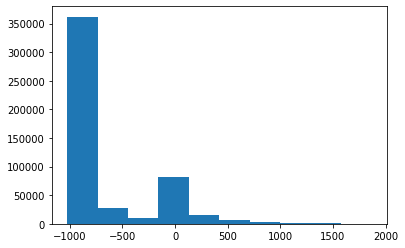

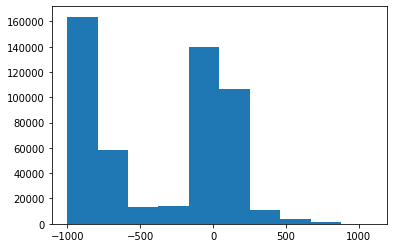

In [130]:
pathxx = '/media/om18/45c77682-c907-4971-84d4-126ad0d801dc2/LUNA16/cycleGAN_aug_10_folds/subset0/'
ff = os.listdir(pathxx)
for idx, i in enumerate(ff):
    if idx==10:break
    a = np.fromfile(f'{pathxx}{i}',dtype='int16').astype('float32').reshape((80,80,80))
    print(sys.getsizeof(a))
    plt.figure()
    plt.hist(a.flatten());

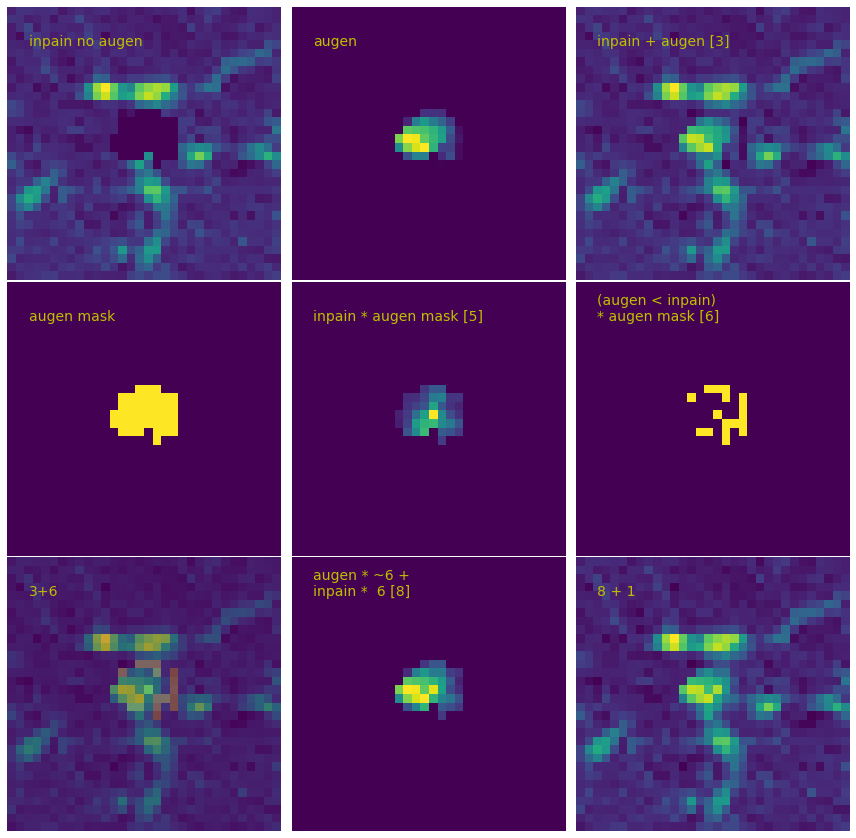

In [15]:
# In more detail:
# We patch the celullar-automata-generated (augen) nodule into the inpainted image (inpain)
x=2; y=4
part1 = ((~mask_overlap).astype(int)*last32)
part2 = ((mask_overlap).astype(int)*ndl_grown[ca_gen])
part3 = (((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen]))
part4 = part2 > 0
part5 = last32 * part4
part6 = part2 < part5
part7 = part2 < orig32*part4
part8 = part2*(~part6) + last32*part6
part9 = part2*(~part6) + last32*part6 + part1*(~part4)
fig, ax = plt.subplots(3,3, figsize=(12,12))
ax[0,0].imshow(part1[15]); ax[0,0].text(x, y, 'inpain no augen', color='y', fontsize=14)
ax[0,1].imshow(part2[15]); ax[0,1].text(x, y, 'augen', color='y', fontsize=14)
ax[0,2].imshow(part3[15]); ax[0,2].text(x, y, 'inpain + augen [3]', color='y', fontsize=14)
ax[1,0].imshow(part4[15]); ax[1,0].text(x, y, 'augen mask', color='y', fontsize=14)
ax[1,1].imshow(part5[15]); ax[1,1].text(x, y, 'inpain * augen mask [5]', color='y', fontsize=14)
ax[1,2].imshow(part6[15]); ax[1,2].text(x, y, '(augen < inpain) \n* augen mask [6]', color='y', fontsize=14)
ax[2,0].imshow(part3[15]); ax[2,0].text(x, y, '3+6', color='y', fontsize=14)
ax[2,0].imshow(part6[15], alpha=.3)
ax[2,1].imshow(part8[15]); ax[2,1].text(x, y, 'augen * ~6 +\ninpain *  6 [8]', color='y', fontsize=14)
ax[2,2].imshow(part9[15]); ax[2,2].text(x, y, '8 + 1', color='y', fontsize=14)

for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
# With correction
offset_ndl = 200
SAVE_FIGS = 400
gen_range = np.arange(100)
# gen_range = np.arange(20,200,3)
generations_multi = []
mselosses, min_losses, min_losses_idx = [], [], []
for idx, name_wrong in tqdm_notebook(enumerate(dict_names.keys()), total=len(dict_names.keys())):
    if idx<=offset_ndl: continue
    if idx==offset_ndl+20: break
    name_correct = dict_names.get(name_wrong)
    assert(name_correct in names_correct)
    
    # read original files and grown nodule
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    last32 = last[16:-16, 16:-16, 16:-16]; orig32 = orig[16:-16, 16:-16, 16:-16]; mask32 = mask[16:-16, 16:-16, 16:-16]
    
    ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
    ndl_grown = ndl_grown.f.arr_0
    mask_ndl_grown = ndl_grown > 0
    
    generations = []
    mseloss = []
    min_loss = 1
    for ca_gen in gen_range:
        mask_overlap  = np.logical_and(mask_ndl_grown[ca_gen], mask32)
        patched = ((~mask_overlap).astype(int)*last32) + ((mask_overlap).astype(int)*ndl_grown[ca_gen])
        patched_corrected, mask_celaut = patch_generated_inpainted_with_extra_mask(mask_overlap, last32, ndl_grown, ca_gen)
        loss_new = np.mean((orig32*mask32 - ndl_grown[ca_gen]*mask32)**2) #loss is against the ca_grown alone (not patched over inpainted)
        if loss_new < min_loss:
            min_loss = loss_new
            ca_gen_min = ca_gen
        else: break
        mseloss.append(loss_new) 
#         if mseloss
        
        
        generations.append(patched_corrected)
        # save a few ID for gif
        if idx % SAVE_FIGS == 0:
            fig_save_automata_growing(name_correct, ca_gen, patched_corrected[15], last32, orig32)
    
    min_losses.append(min_loss) ; min_losses_idx.append(ca_gen_min)
        
    generations_multi.append(generations)
    mselosses.append(mseloss)
    
    if idx % SAVE_FIGS == 0:
        fig_read_figs_and_make_gif(name_correct) # Make GIF
    
    
    
    

In [255]:
for i in np.arange(1,1161):
    if 65536 **(1/(i**3)) %1 ==0:
        print(i)

1
2


In [284]:
# check previous format: read augmented data from cycleGAN 
path_augmented_data = '/media/om18/45c77682-c907-4971-84d4-126ad0d801dc2/LUNA16/cycleGAN_aug_10_folds/subset0/'
ffA = os.listdir(path_augmented_data)
a = np.fromfile(f'{path_augmented_data}{ffA[0]}',dtype='int16').astype('float32').reshape((80,80,80))
print(np.shape(a))

(80, 80, 80)


In [287]:
# check previous format: read augmented data from cycleGAN 
path_augmented_data = '/data/OMM/project results/Feb 20 19 - CycleGan clean/deep nodule prior luna v2 - cubes size 32 coefficients/images augmented/patched/subset0/'
ffA = os.listdir(path_augmented_data)
a = np.fromfile(f'{path_augmented_data}{ffA[0]}',dtype='int16').astype('float32').reshape((80,80,80))
print(np.shape(a))

(80, 80, 80)


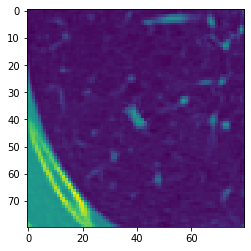

In [285]:
plt.imshow(a[40])

(80, 80, 80)


In [245]:
a = np.fromfile(f'{path_augmented_data}{ffA[0]}',dtype='int16').astype('float32')
print(np.shape(a))


(65536,)


IndexError: too many indices for array

In [232]:
a = np.fromfile(f'{path_augmented_data}{ffA[0]}',dtype='int16').astype('float32').reshape((80,80,80))
np.shape(a)

ValueError: cannot reshape array of size 65536 into shape (80,80,80)

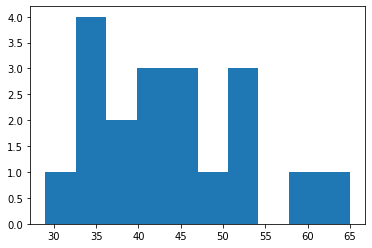

In [217]:
plt.hist(min_losses_idx);

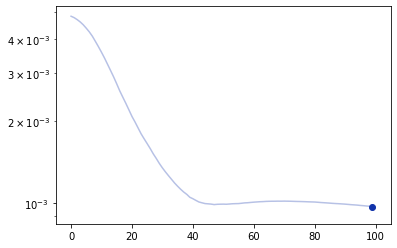

In [211]:
for idx, (loss, min_value, min_idx) in enumerate(zip(mselosses, min_losses, min_losses_idx)):
    if idx==16:
        plt.plot(loss, c='#1133AA', alpha=.3)
        plt.scatter(min_idx, min_value, c='#1133AA')
        ax = plt.gca(); ax.set_yscale('log')

IndexError: too many indices for array

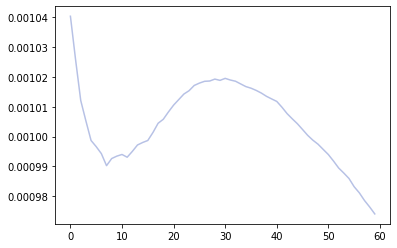

In [212]:
for idx, (loss, min_value, min_idx) in enumerate(zip(mselosses[16:], min_losses[16:], min_losses_idx[16:])):
    if idx==0:
        plt.plot(loss[40:], c='#1133AA', alpha=.3)
        plt.scatter(np.asarray(min_idx)[40:], np.asarray(min_value)[40:], c='#1133AA')
        ax = plt.gca(); ax.set_yscale('log')

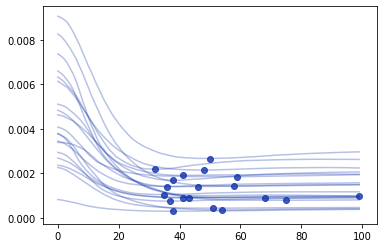

In [200]:
for loss, min_value, min_idx in zip(mselosses, min_losses, min_losses_idx):
    plt.plot(loss, c='#1133AA', alpha=.3)
    plt.scatter(min_idx, min_value, c='#1133AA', alpha=.8)

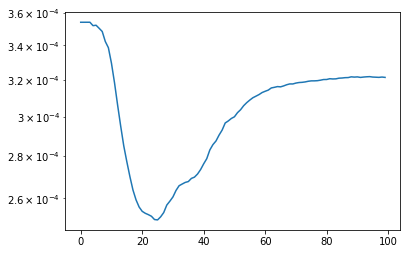

In [158]:
xx = []
for i in generations_multi[2]:
    xx.append(np.mean((orig32*mask32 - i*mask32)**2))
plt.semilogy(xx)

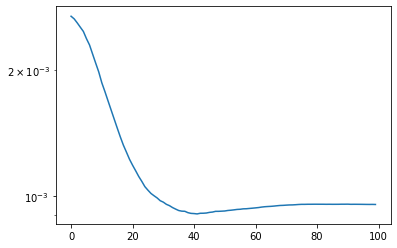

In [156]:
xx = []
for i in ndl_grown[:100]:
    xx.append(np.mean((orig32*mask32 - i*mask32)**2))
plt.semilogy(xx)

0.0

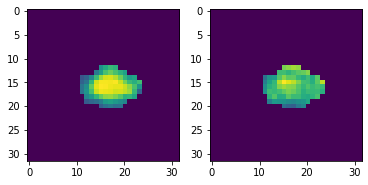

In [133]:
fig, ax = plt.subplots(1,2)
ax[0].imshow((orig32*mask32)[15])
ax[1].imshow((generations[0]*mask32)[15])
np.median(((orig32*mask32) - (patched_corrected*mask32))**2)

In [31]:
print(files_sorted[0])
a = np.load('/home/om18/Downloads/files_sorted_maybe_old.npy')
a[0]

1.3.6.1.4.1.14519.5.2.1.6279.6001.842317928015463083368074520378_block2_10_z166y114x247.raw


'1.3.6.1.4.1.14519.5.2.1.6279.6001.842317928015463083368074520378_block2_10_z166y114x247.raw'

(32, 32, 32) (32, 32, 32) (32, 32, 32)


0.00032091437666379146

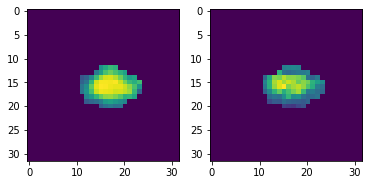

In [125]:
print(np.shape(orig32), np.shape(mask32), np.shape(patched_corrected))
fig, ax = plt.subplots(1,2)
ax[0].imshow((orig32*mask32)[15])
ax[1].imshow((patched_corrected*mask32)[15])
np.mean(((orig32*mask32) - (patched_corrected*mask32))**2)

1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084_block2_0_z105y172x259.raw
1.3.6.1.4.1.14519.5.2.1.6279.6001.199261544234308780356714831537_block1_10_z341y133x83.raw
1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_block2_432_z225y165x272.raw


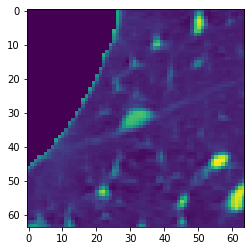

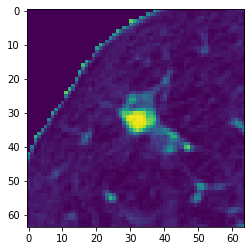

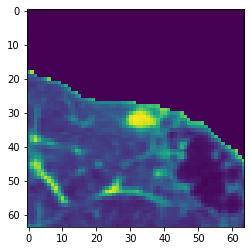

In [92]:
for idx, name_wrong in enumerate(dict_names.keys()):
    if idx<=offset_ndl: continue
    if idx==offset_ndl+4: break
    name_correct = dict_names.get(name_wrong)
    last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
    plt.figure()
    plt.imshow(orig[31])
    print(name_correct)

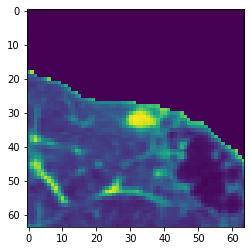

In [90]:
a1 = '1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084_block2_0_z105y172x259.raw'
a2 = '1.3.6.1.4.1.14519.5.2.1.6279.6001.199261544234308780356714831537_block1_10_z341y133x83.raw'
a3 = '1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886_block2_432_z225y165x272.raw'
last, orig, mask, mask_lungs = get_raw_nodule(path_data, a3)
plt.imshow(orig[31])

In [94]:
os.remove('gifs/images_before_gifs/')

IsADirectoryError: [Errno 21] Is a directory: 'gifs/images_before_gifs/'

In [41]:
generations_single = generations_multi[0]
generations_single = np.asarray(generations_single)[:,15,:,:]
print(np.shape(generations_multi), np.shape(generations_single))

(1, 60, 32, 32, 32) (60, 32, 32)


In [75]:
def fig_save_automata_growing(ID, idx, i, last32, orig32, vmin=0, vmax=1, folder='gifs/images_before_gifs/'):
    fig, ax = plt.subplots(1,3,figsize=(8.5,3))
    ax[0].imshow(last32[15], vmin=vmin, vmax=vmax)
    ax[0].text(2,2,'inpain',color='y', fontsize=12)
    ax[1].imshow(i, vmin=vmin, vmax=vmax)
    ax[1].text(2,2,f'cel aut {idx}',color='y', fontsize=12)
    ax[2].imshow(orig32[15], vmin=vmin, vmax=vmax)
    ax[2].text(2,2,'orig',color='y', fontsize=12)
    for axx in ax.ravel(): axx.axis('off')
    fig.tight_layout()
    plt.savefig(f'{folder}{ID}_{idx:04d}.png')
    plt.close()

In [76]:
for idx, i in enumerate(generations_single):
    fig_save_automata_growing('test', idx, i, last32, orig32)
fig_read_figs_and_make_gif('test')

In [95]:
def fig_read_figs_and_make_gif(ID, folder='gifs/images_before_gifs/'):
    files_figures = os.listdir(folder)
    files_figures = np.sort(files_figures)
    images_all = []
    for i in files_figures:
        a = imageio.mimread(f'{folder}{i}')
        os.remove(f'{folder}{i}')
        images_all.append(a[0])
    imageio.mimsave(f'gifs/{ID}.gif', images_all, duration=.3)

In [68]:
files_figures = os.listdir('gifs/images_before_gifs/')
files_figures = np.sort(files_figures)
a = imageio.mimread(f'gifs/images_before_gifs/{files_figures[0]}')

In [71]:
files_figures = os.listdir('gifs/images_before_gifs/')
files_figures = np.sort(files_figures)
images_all = []
for i in files_figures:
    a = imageio.mimread(f'gifs/images_before_gifs/{i}')
    images_all.append(a[0])
imageio.mimsave('movie.gif', images_all, duration=.5)

59

(array([186., 654., 100.,  32.,  13.,   8.,   8.,   6.,   7.,  10.]),
 array([0.        , 0.07841455, 0.15682911, 0.23524366, 0.31365821,
        0.39207277, 0.47048732, 0.54890187, 0.62731643, 0.70573098,
        0.78414553]),
 <a list of 10 Patch objects>)

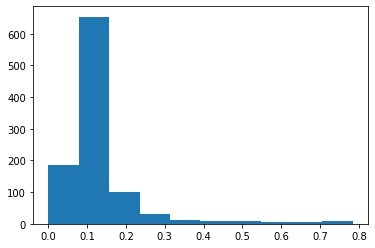

In [232]:
plt.hist(generations_single[9].flatten())

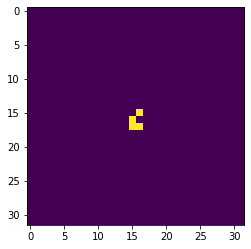

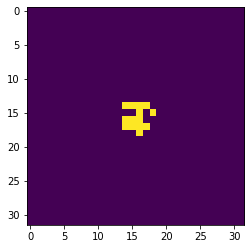

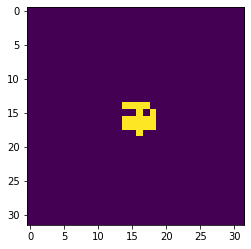

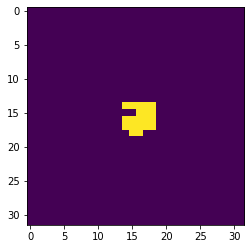

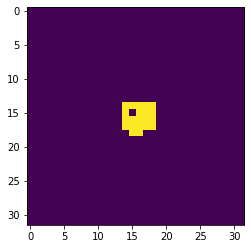

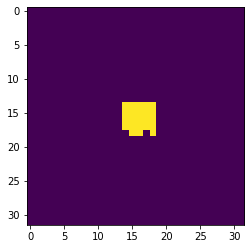

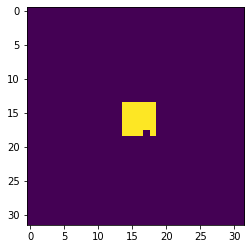

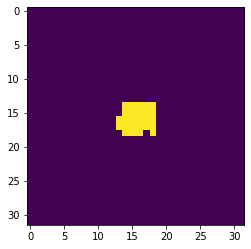

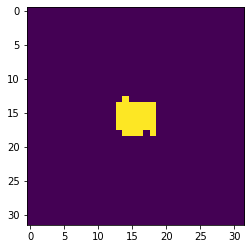

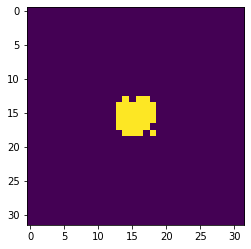

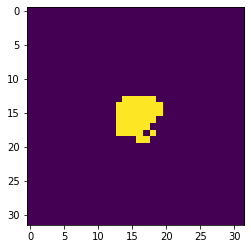

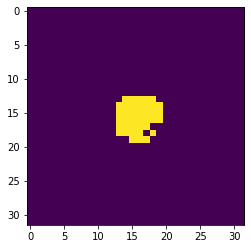

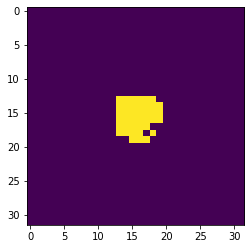

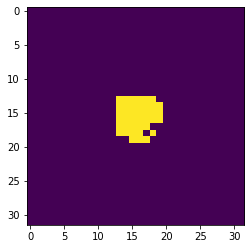

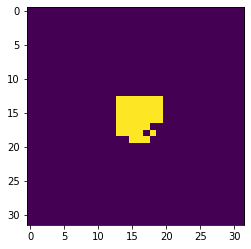

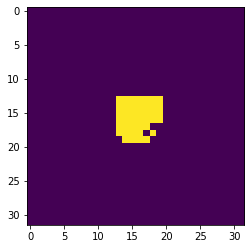

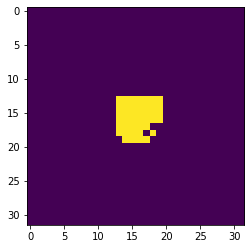

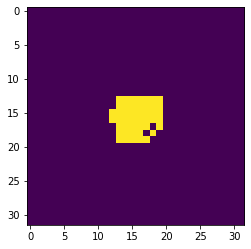

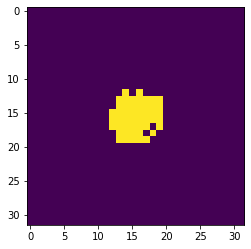

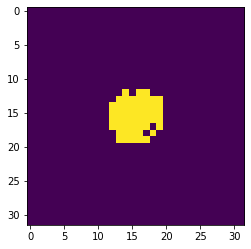

In [71]:
for idx, i in enumerate(mask_ndl_grown):
    if idx==20: break
    plt.figure()
    plt.imshow(i[15])

In [ ]:
mask_ndl_grown = ndl_grown > 0
ca_patched = np.zeros_like(ndl_grown)
for idx, i in enumerate(ndl_grown):
    ca_patched[idx] = (~mask_ndl_grown_shifted2[idx]*last32) + (mask_ndl_grown_shifted2[idx]*i)

In [89]:
np.sum(mask_ndl_grown[15]), np.sum(mask32)

(642, 570.0)

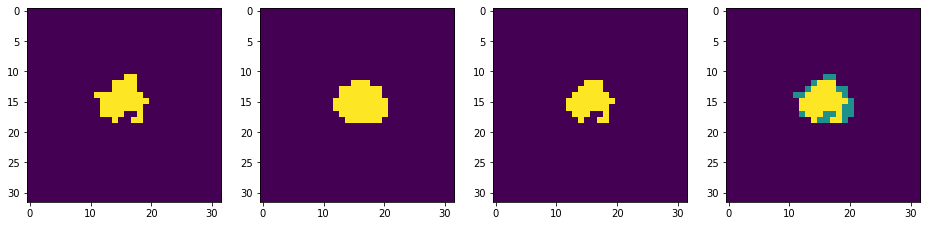

In [103]:
aa = np.logical_and(mask_ndl_grown[15],mask32)
fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].imshow(mask_ndl_grown[15][15])
ax[1].imshow(mask32[15])
ax[2].imshow(aa[15])
ax[3].imshow(mask_ndl_grown[15][15] + mask32[15])

In [81]:
np.shape(((mask_ndl_grown[ca_gen]).astype(int)*ndl_grown[ca_gen]))

(32, 32, 32)

In [47]:
len(np.unique(names_correct)), len(np.unique(files_done))

(288, 288)

In [44]:
len(list(set(names_correct).intersection(set(files_done))))

37

In [17]:
# Make sure the nodule visualized is in the names_correct
assert(name_correct in names_correct)

(64, 64, 64) (64, 64, 64)


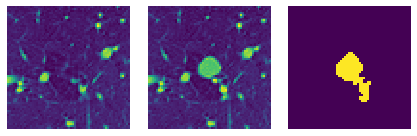

In [129]:
name_wrong = files_done[-1]
name_correct = dict_names.get(name_wrong)
name_correct_zyx = dict_zyx.get(name_wrong)
last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
print(np.shape(last), np.shape(orig))
fig, ax = plt.subplots(1,3, figsize=(6,2));
ax[0].imshow(last[31])
ax[1].imshow(orig[31])
ax[2].imshow(mask[31])
for axx in ax.ravel(): axx.axis('off')
fig.tight_layout()

In [130]:
# Since we performed the nodule growth with the wrong names we have to load the results with the wrong name
ndl_grown = np.load(f'{path_source}{name_wrong}.npz')
ndl_grown = ndl_grown.f.arr_0
print(np.shape(ndl_grown))
print(name_correct_zyx)

(500, 32, 32, 32)
[25 24 24 39 49 42 15 26 19]


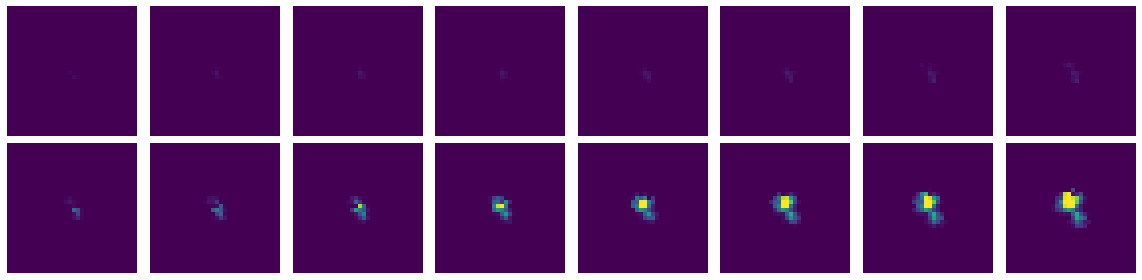

In [131]:
fig_multiple3D(ndl_grown,2,8)

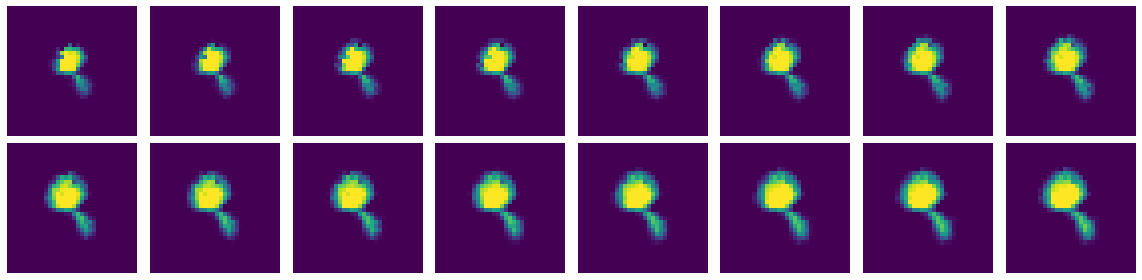

In [132]:
fig_multiple3D(ndl_grown[20:], 2,8)

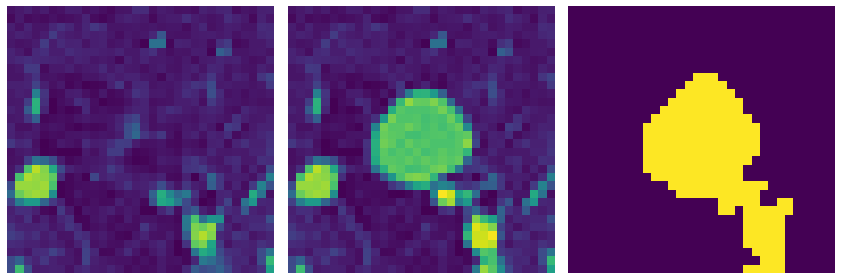

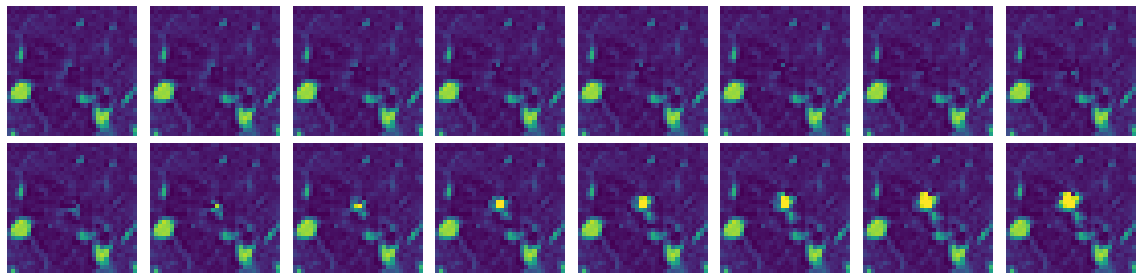

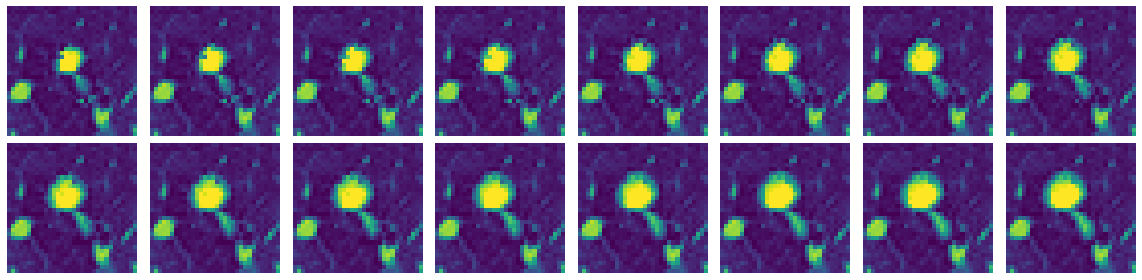

In [135]:
last, orig, mask, mask_lungs = get_raw_nodule(path_data, name_correct)
last32 = last[16:-16, 16:-16, 16:-16]
orig32 = orig[16:-16, 16:-16, 16:-16]
mask32 = mask[16:-16, 16:-16, 16:-16]
mask_ndl_grown = ndl_grown > 0
ca_patched = np.zeros_like(ndl_grown)
ca_mask = np.zeros_like(ndl_grown)
for idx, i in enumerate(ndl_grown):
    ca_patched[idx] = (~mask_ndl_grown[idx]*last32) + (mask_ndl_grown[idx]*i)
    ca_mask[idx] = (mask_ndl_grown[idx])>0

fig, ax = plt.subplots(1,3, figsize=(12,4));
ax[0].imshow(last32[15], vmin=0, vmax=1); ax[1].imshow(orig32[15], vmin=0, vmax=1); ax[2].imshow(mask32[15], vmin=0, vmax=1)
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

fig_multiple3D(ca_patched[1:], 2,8)
fig_multiple3D(ca_patched[20:], 2,8)

In [137]:
ca_patched_every_2 = [i for idx, i in enumerate(ca_patched) if idx%2==0]
np.shape(ca_patched_every_2)

(250, 32, 32, 32)

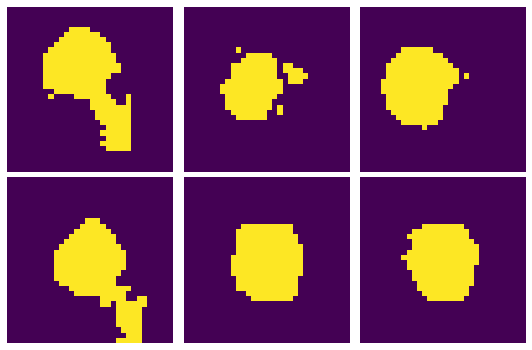

In [134]:
ca_gen = 60
fig, ax = plt.subplots(2,3, figsize=(7.5,5));
ax[0,0].imshow(ca_mask[ca_gen][15], vmin=0, vmax=1); ax[1,0].imshow(mask32[15], vmin=0, vmax=1); 
ax[0,1].imshow(ca_mask[ca_gen][:,15,:], vmin=0, vmax=1), ax[1,1].imshow(mask32[:,15,:], vmin=0, vmax=1)
ax[0,2].imshow(ca_mask[ca_gen][:,:,15], vmin=0, vmax=1), ax[1,2].imshow(mask32[:,:,15], vmin=0, vmax=1)
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

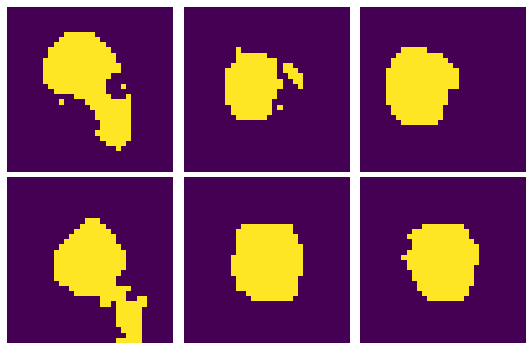

In [133]:
fig, ax = plt.subplots(2,3, figsize=(7.5,5));
ax[0,0].imshow(ca_mask[50][15], vmin=0, vmax=1); ax[1,0].imshow(mask32[15], vmin=0, vmax=1); 
ax[0,1].imshow(ca_mask[50][:,15,:], vmin=0, vmax=1), ax[1,1].imshow(mask32[:,15,:], vmin=0, vmax=1)
ax[0,2].imshow(ca_mask[50][:,:,15], vmin=0, vmax=1), ax[1,2].imshow(mask32[:,:,15], vmin=0, vmax=1)
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

In [ ]:
last32 = last[16:-16, 16:-16, 16:-16]
orig32 = orig[16:-16, 16:-16, 16:-16]
mask32 = mask[16:-16, 16:-16, 16:-16]
mask_ndl_grown = ndl_grown > 0
ca_patched = np.zeros_like(ndl_grown)
for idx, i in enumerate(ndl_grown):
    ca_patched[idx] = (~mask_ndl_grown[idx]*last32) + (mask_ndl_grown[idx]*i)

fig, ax = plt.subplots(1,3, figsize=(6,2));
ax[0].imshow(last32[15], vmin=0, vmax=1); ax[1].imshow(orig32[15], vmin=0, vmax=1); ax[2].imshow(mask32[15], vmin=0, vmax=1)
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

fig_multiple3D(ca_patched[10:], 2,8)
fig_multiple3D(ca_patched[100:], 2,8)

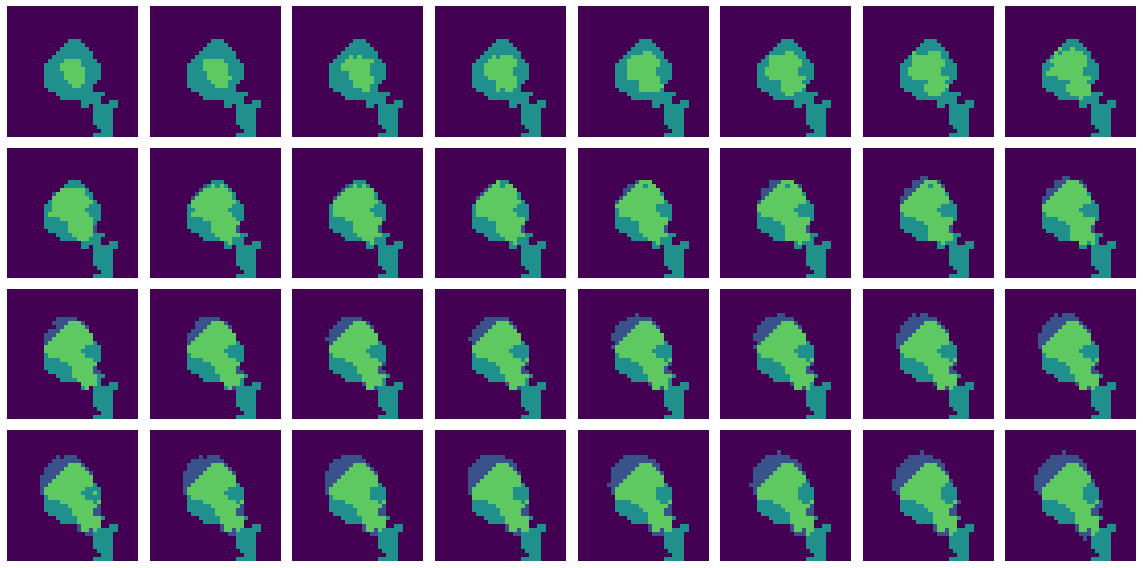

In [107]:
offset=10
last32 = last[16:-16, 16:-16, 16:-16]
mask32 = mask[16:-16, 16:-16, 16:-16]
mask_ndl_grown = ndl_grown > 0
ca_patched = np.zeros_like(ndl_grown)
for idx, i in enumerate(ndl_grown[offset:]):
    ca_patched[idx] = (mask32) + (mask_ndl_grown[idx+offset])*.5
fig_multiple3D(ca_patched, 4,8, vmin=0, vmax=2)

In [113]:
name_correct_zyx - 16//2

array([17, 16, 16, 31, 41, 34,  7, 18, 11])

In [98]:
np.shape(mask32)

(32, 32, 32)

In [25]:
name_correct_zyx

array([25, 24, 24, 39, 49, 42, 15, 26, 19])

In [46]:
from scipy.ndimage.interpolation import shift

In [48]:
mask_ndl_grown_shifted = shift(mask_ndl_grown, (0, 9, 8, 8), cval=0)

In [100]:
mask_ndl_grown_shifted2 = []
for idx, i in enumerate(mask_ndl_grown):
#     if idx==10:break
    new_zeros = np.zeros_like(i)
    zz, yy, xx = np.where(i==1)
    zz = zz + (name_correct_zyx[6] - 16//2)
    yy = yy + (name_correct_zyx[7] - 16//2)
    xx = xx + (name_correct_zyx[8] - 16//2)
    # WARNING THESE CLIP MAYBE SHOUD BE REMOVED
    xx = np.clip(xx,0,31)
    yy = np.clip(yy,0,31)
    zz = np.clip(zz,0,31)
    
    new_zeros[zz,yy,xx]=1
    mask_ndl_grown_shifted2.append(new_zeros)

(500, 32, 32, 32)


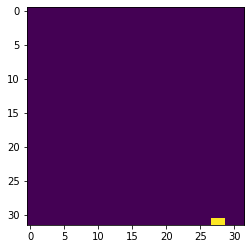

In [111]:
print(np.shape(mask_ndl_grown_shifted2))
plt.imshow(mask_ndl_grown_shifted2[0][24])

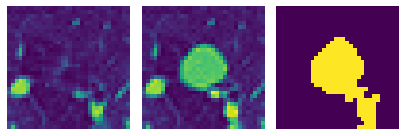

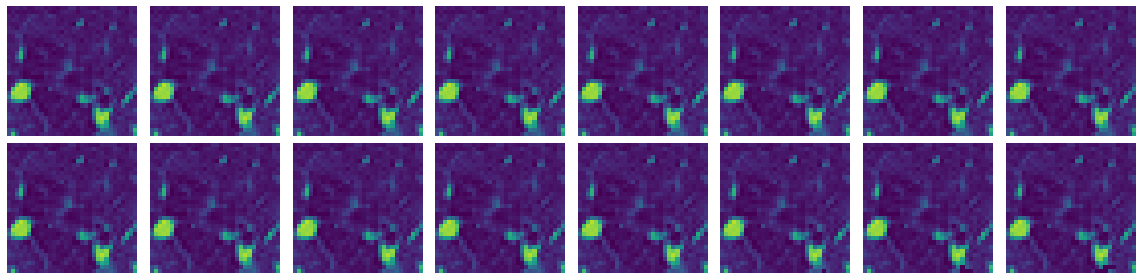

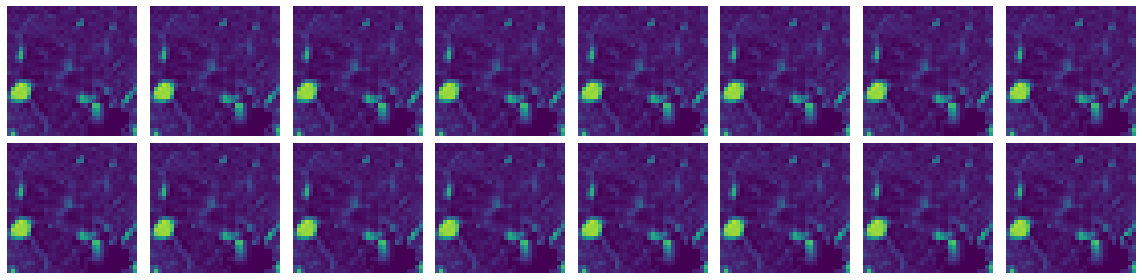

In [102]:
last32 = last[16:-16, 16:-16, 16:-16]
orig32 = orig[16:-16, 16:-16, 16:-16]
mask32 = mask[16:-16, 16:-16, 16:-16]
mask_ndl_grown = ndl_grown > 0
ca_patched = np.zeros_like(ndl_grown)
for idx, i in enumerate(ndl_grown):
    ca_patched[idx] = (~mask_ndl_grown_shifted2[idx]*last32) + (mask_ndl_grown_shifted2[idx]*i)

fig, ax = plt.subplots(1,3, figsize=(6,2));
ax[0].imshow(last32[15], vmin=0, vmax=1); ax[1].imshow(orig32[15], vmin=0, vmax=1); ax[2].imshow(mask32[15], vmin=0, vmax=1)
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

fig_multiple3D(ca_patched[10:], 2,8)
fig_multiple3D(ca_patched[100:], 2,8)

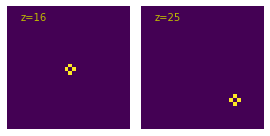

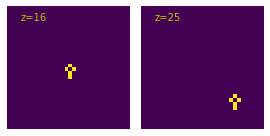

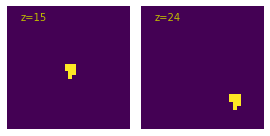

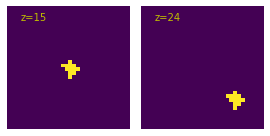

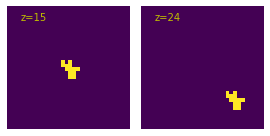

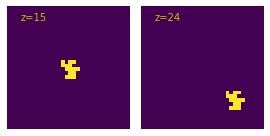

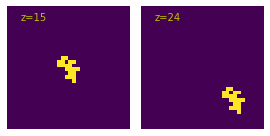

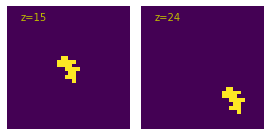

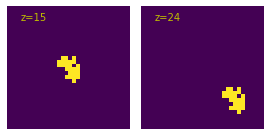

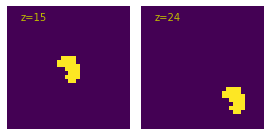

In [84]:
for idx, (i, j) in enumerate(zip(mask_ndl_grown, mask_ndl_grown_shifted2)):
    if idx==10:break
    z1, y1, x1 = np.where(i==1)
    z2, y2, x2 = np.where(j==1)
    zz1 = int(np.median(z1))
    zz2 = int(np.median(z2))
    
    
    fig, ax = plt.subplots(1,2, figsize=(4,2))
    ax[0].imshow(i[zz1])
    ax[0].text(3,3,f'z={zz1}', color='y')
    ax[1].imshow(j[zz2])
    ax[1].text(3,3,f'z={zz2}', color='y')
    for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

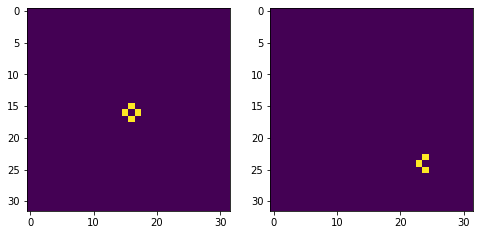

In [81]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(mask_ndl_grown[0][16])
ax[1].imshow(mask_ndl_grown_shifted[0][25])

In [35]:
zz, yy, xx = np.where(a==1)
print(zz, yy, xx)
zz = zz + (name_correct_zyx[0] - 16)
yy = yy + (name_correct_zyx[1] - 16)
xx = xx + (name_correct_zyx[2] - 16)
print(zz, yy, xx)
mask_shifted = np.zeros_like(a)
mask_shifted[zz,yy,xx]=1

[15 15 15 15 16 16 16 16 17 17 17] [15 16 17 17 15 16 16 17 16 17 17] [17 15 16 17 16 15 17 16 17 16 17]
[24 24 24 24 25 25 25 25 26 26 26] [23 24 25 25 23 24 24 25 24 25 25] [25 23 24 25 24 23 25 24 25 24 25]


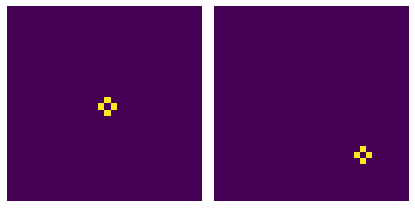

In [80]:
mask_ndl_grown = ndl_grown > 0
z_median = int(np.median(zz))
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].imshow(a[16])
ax[1].imshow(mask_shifted[25])
for axx in ax.ravel(): axx.axis('off'); fig.tight_layout()

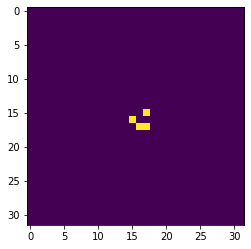

In [31]:
a = mask_ndl_grown[0]
plt.imshow(a[15])

## X. Losses

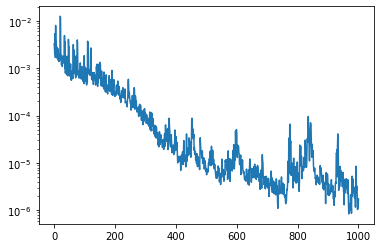

In [9]:
# Loss
i = files_loss[0]
loss = np.load(f'{path_source}{i}')
plt.semilogy(loss)

# Old code

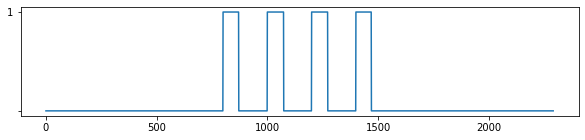

In [9]:
files_done_idx, files_done = [], []
for idx, i in enumerate(files_sorted):
    if i in files_ndls_raw:
        files_done_idx.append(idx)
        files_done.append(i)
files_sorted_zeros = np.zeros_like(files_sorted)
files_sorted_zeros[files_done_idx]= 1
plt.figure(figsize=(10,2))
plt.plot(files_sorted_zeros);